# Chapter 9 - Markov Chain Monte Carlo

- Estimate the posterior probability distribution using **Markov Chain Monte Carlo**.
- Benefits:
    - Produces samples from the posterior directly
    - No need to assume multivariate normality
- Downsides:
    - Takes longer to compute
    - Usu. more work is required to specify the model
- Use `Stan` to generate the Markov chains from the `quap` models
- (But for now it'll mostly be hidden behind utility functions from the `rethinking` package)

## Good King Markov and his island kingdom

- King Markov lived on a chain of 10 islands. The second island had twice as many as the first, the third three times as many, and so on
- He agrees to visit the islands in proportion to their population (so he visits the 10th island ten times as often as the first island)
- Doesn't want to plan anything in advance, and wants to only visit adjacent islands
- Solution: the **Metropolis Algorithm**:
    - Wherever the King is, he diecides between staying put for another week or moving to one of the adjacent islands by flipping a coin
    - If the coin is heads, he is deciding whether to move clockwise; tails, deciding counterclockwise. The island he is deciding on is the *proposal island*
    - Counts out a number of *seashells* equal to the population of the proposal island and a number of *stones* equal to the population of the current island.
    - If there are more seashells than stones, he always moves. If there are fewer shells than stones, he discards a number of stones equal to the number of shells. E.g. 4 shells, 6 stones -> end with 4 shells and 6 - 4 = 2 stones. Then put the shells and remaining stones in a bag and pulls out one object. If it's a shell, he moves to the proposal island and overwise stays put. In other words, the probabilty that he moves is equal to the number of shells divided by the original number of stones.

In [1]:
library('ggplot2')
library('rethinking')
library(repr)

# Change plot size
options(repr.plot.width=14, repr.plot.height=7)

Loading required package: rstan

Loading required package: StanHeaders

Warning message:
“package ‘StanHeaders’ was built under R version 4.2.0”
rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: cmdstanr

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/eric/.cmdstan/cmdstan-2.31.0

- CmdStan version: 2.31.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

Loading required package: parallel

rethinking (Version 2.31)


Attaching package: ‘rethinking’


The following object is masked from ‘package:rstan’:

    stan


The following object is masked from ‘packag

In [2]:
NUM_WEEKS <- 1e4
positions <- rep(0, NUM_WEEKS) # island number on week n
position = 10
for (i in 1:NUM_WEEKS) {
    positions[i] <- position
    proposal_position <- ifelse(runif(1, 0, 1) < 0.5, position - 1, position + 1)
    # move it into the correct range
    if (proposal_position < 1) proposal_position <- 1
    if (proposal_position > 10) proposal_position <- 10
    prob_move <- proposal_position / position
    position <- ifelse(runif(1, 0, 1) < prob_move, proposal_position, position)
}

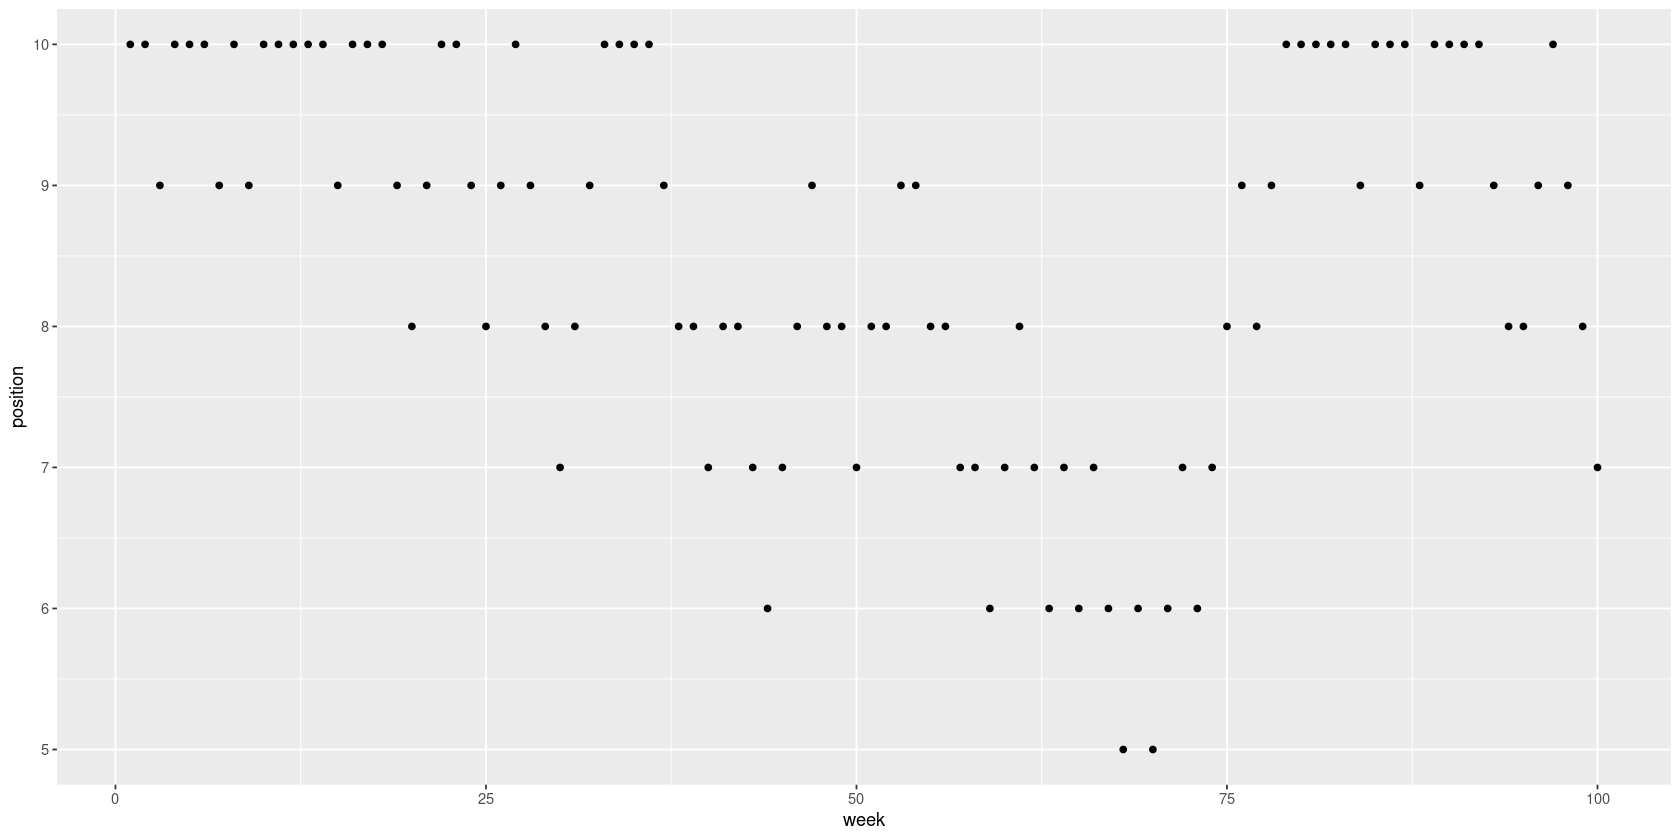

In [3]:
plot_df <- data.frame(week=1:100, position=positions[1:100])
ggplot(plot_df, aes(week, position)) +
    geom_point()

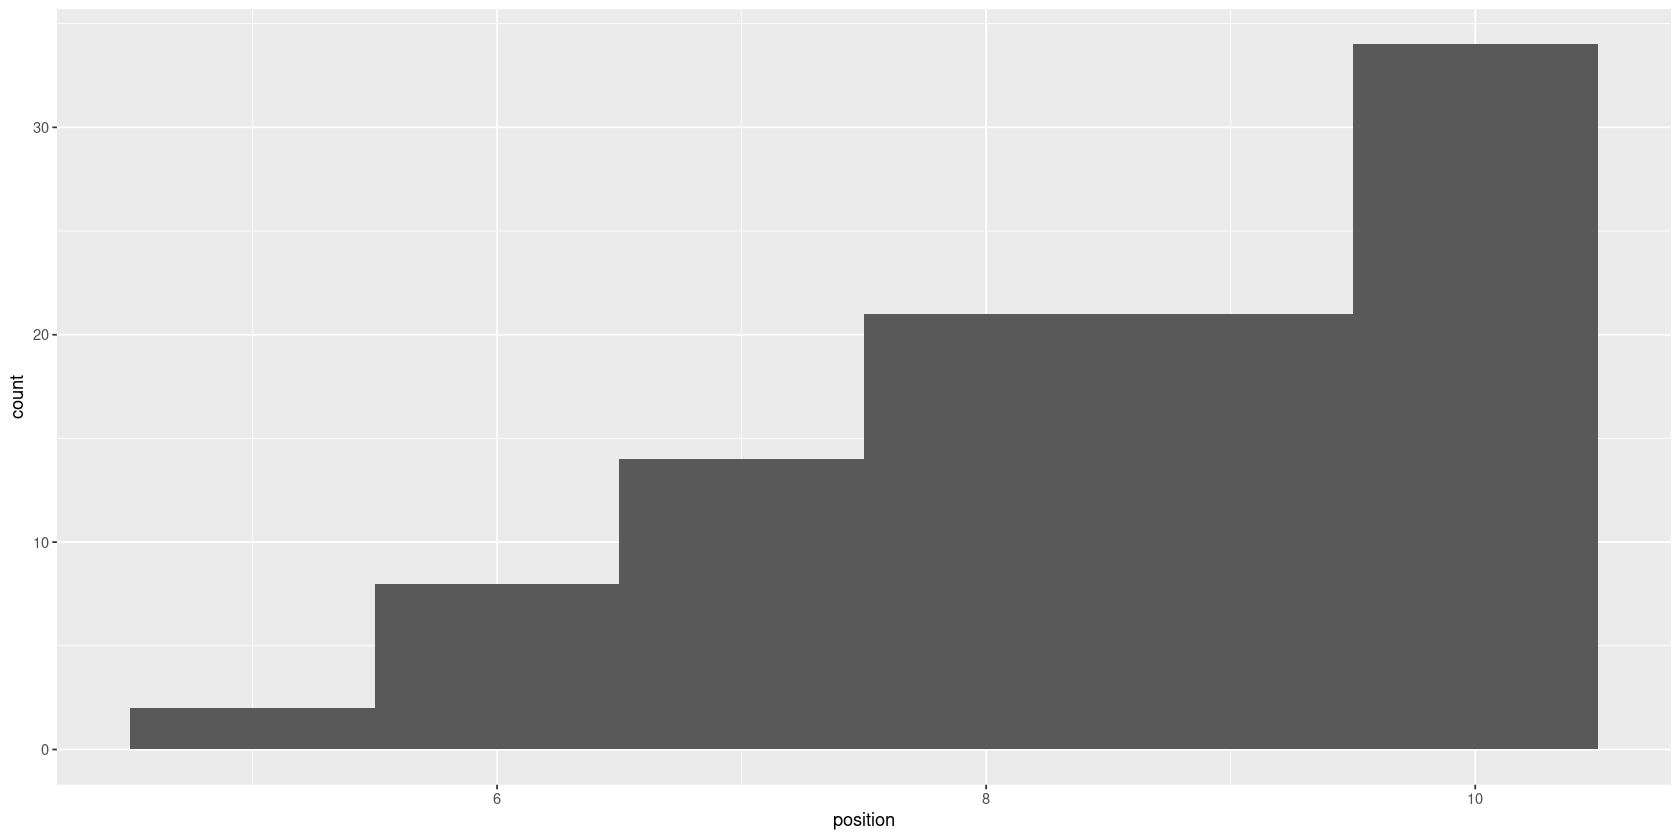

In [4]:
ggplot(plot_df, aes(position)) +
    geom_histogram(binwidth=1) 

Despite the seeming nonsense, this is producing a recognizable result - each island is visited in proportion to its population! In fact, we don't even need to have him move to only adjacent islands - as long as the probability rule for moving vs. staying is the same, we'll get the same result.

## Metropolis algorithms

This is a special case of the more general **Metropolis Algorithm**. This is an example of Markov Chain Monte Carlo. The real application is to draw samples from an unknown and probably complex distribution (e.g. posterior probability distribution).
- "Islands": parameter values for the distribution (not necessarily discrete)
- "Population size": posterior probabilityies at each parameter value
- "Weeks" in the objective are samples takes from the joint posterior of the parameters of the model

As long as the way that we choose our proposed parameter values is symmetric (e.g. $A \to B$ has the same probability as $B \to A$) then the Metropolis algorithm will eventually give us a collection of samples from the joint posterior.

The **Metropolis Algorithm** is the grandparent of many other algorithms. We'll explore **Gibbs Sampling**, which is still commonly used but is being rapidly supplanted by other algorithms.

### Gibbs Sampling

**Metropolis Algorithm** works as long as the proposals are symmetric. There is a more general method, the **Metropolis-Hastings Algorithm**, which allows for asymmetry (so e.g. the coin could be biased to prefer a clockwise direction).

Why would we care about this? One reason is for parameters (e.g. standard deviation) where there is a hard cut off (at zero). A better reason is that allows exploring the posterior *more efficiently*. The most common way to generate these *savvy proposals* is by using **Gibbs Sampling**. This is a variant of **Metropolis-Hastings** that uses better proposals to be more efficient. The improvements come from *adaptive proposals* in which the distribution of proposed parameter values adjusts itself depending on the parameter values at the moment.

It depends on using particular combinations of prior distributions and likelihoods (**conjugate pairs**). These can be analytically computed to allow the sampler to make smart jumps around the joint posterior of all parameters.

In practice it is quite efficient and forms the basis of **BUGS** (Bayesian inference Using Gibbs Sampling) and **JAGS** (Just Anothre Gibbs Sampler).

### High-dimensional problems

There are several limitations.
- Maybe you don't want to use conjugate priors. These can even be pathological once you get into multilevel models.
- As models become more complex and start to have hundreds or thousands of models, the sampler can get 'stuck' in high-probability regions. The problem is actually that there often exist high correlations between the different variables which create high-probability ridges where the sampler gets stuck.

The high-correlation example ilustrates a far deeper and more interesting problem, called **Concentration of Measure**. This is the fact that in higher-dimensional distributions, most of the probability mass is always far from the mode. This means that the values that maximize the posterior probability (mode) is not in a region where the parameter values are plausible (meaning the sampler won't spend much time there).



In [5]:
# Example of the curse of dimensionality

plot_df <- data.frame(
    values=double(),
    D=integer()
)
Dims <- c(1, 10, 100, 1000)
for (D in Dims) {
    T <- 1e4
    Y <- rmvnorm(T, rep(0, D), diag(D))
    rad_dist <- function(Y) sqrt(sum(Y ^ 2))
    Rd <- sapply(1:T, function(i) rad_dist(Y[i,]))
    df <- data.frame(values=Rd, D=as.factor(D))
    plot_df <- rbind(plot_df, df)
}

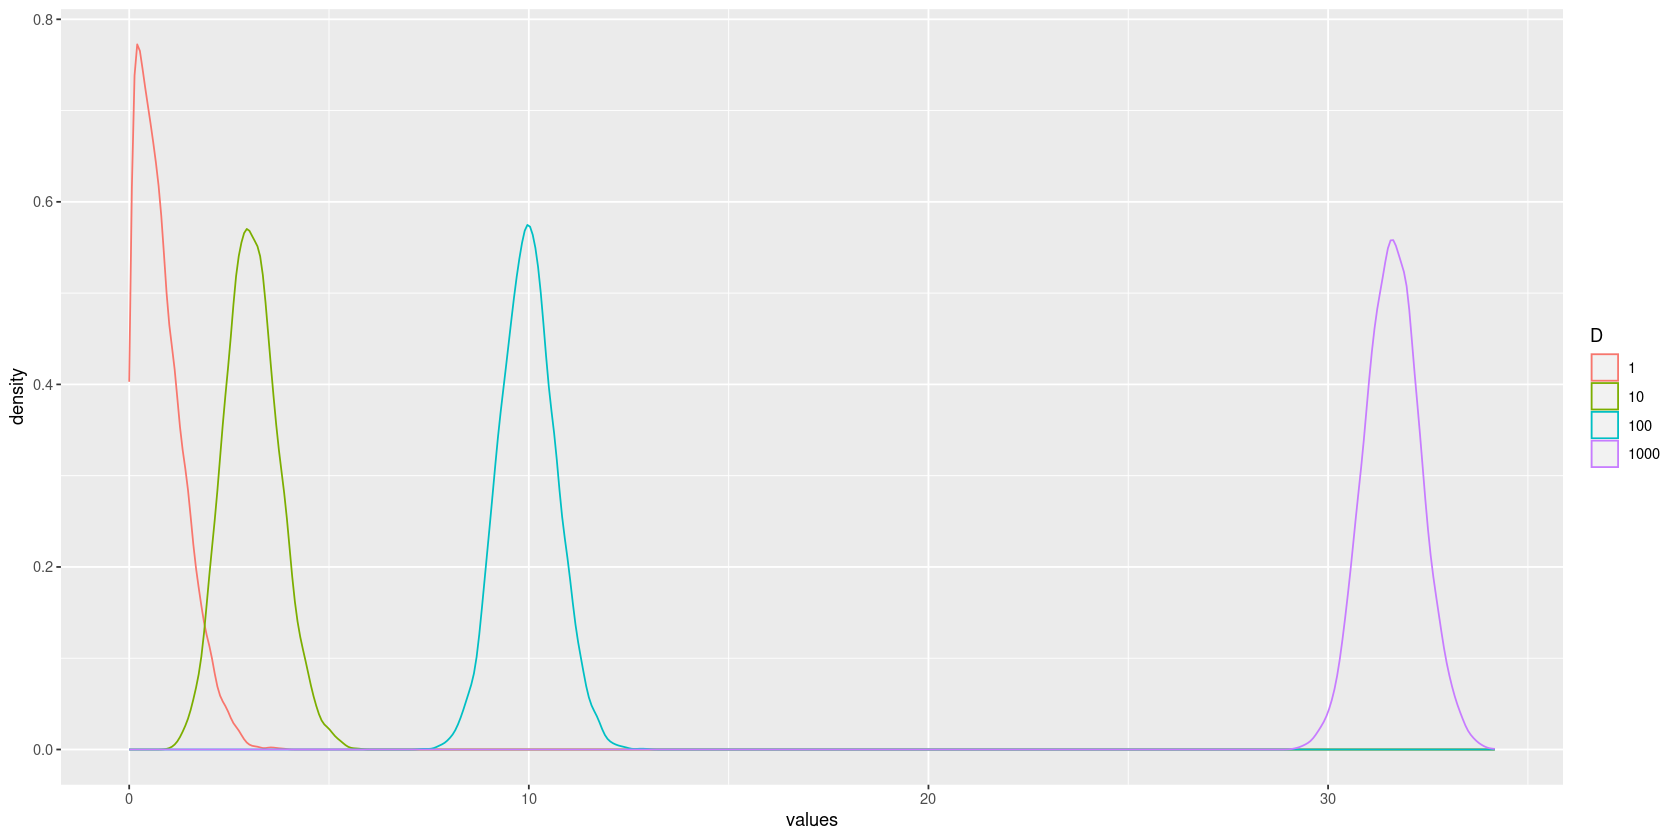

In [6]:
ggplot(plot_df, aes(x=values, colour=D)) +
    geom_density()

So here you can see that the radial distance from the mode (x axis) is increasing substantially with the number of dimensions.

This is why we need MCMC algorithms that consider the whole posterior at once, not just a few dimensions at a time (like the Metropolis or Gibbs algorithms).

## Hamiltonian Monte Carlo

General principle: when  you have a random process, there is often a less-random process which is more work but gives you better results.

**Hamiltonian Monte Carlo** (aka Hybrid Monte Carlo) is less random and more work than the Gibbs sampler, but gives better results with fewer samples. Overall, it is more efficient.

### Another Parable

Say we have another king, Monty, living on the mainland. Monty's territory is a continuous narrow valley running north-south. King has a similar obligation to visit the citixens in proportion to their local population density.

Within the valley, people distribute themselves inversely proportionally to elevation - fewer people near the top of mountains and more people in the valleys.

Here's the method:
- King's vehicle picks a random direction (north or south) and momentum. As the vehicle goes uphill, it slows down and turns around when its declining momentum forces it to, gaining momentum when going downhill.
- After a fixed period of time, they get out and visit the people
- Then they start again

The **autocorrelation** between locations visited is very low; there is almost no correlation between adjacent locations.

### Particles in space

In statistical applications, the royal car is the current vector of parameter values. We'll consider just the single-parameter case. In that case, the log-posterior is like a bowl with the point of highest posterior probability at its nadir, in the centre of the valley. Then we give it a random flick and simulate its path.

In principle, **HMC** will always accept every proposal. However, in practice we usually put a rejection criterior because we are only *approximating* the smooth path of a particle. Usually we see very high acceptance rates. The rejection criterion usually has something to do with the total energy of the system and ensuring that it is more-or-less conserved.

We'll do a 2D version

Say the data are 100 $x$ and $y$ values sampled from a standard normal distribution.

$$
\begin{align*}
x_i \sim \text{Normal}(\mu_x, 1) \\
y_i \sim \text{Normal}(\mu_y, 1) \\
\mu_x \sim \text{Normal}(0, 0.5) \\
\mu_y \sim \text{Normal}(0, 0.5)
\end{align*}
$$

WhatHMC needs is two functions and two settings.
First function computes the log-probability of the data and parameters. This is the top part of **Bayes' Rule**, and every MCMC strategy needs it. It computes the 'height' of any set of parameter values. For us:

$$
\sum_i \log p (y_i | \mu_y, 1) + \sum_i \log p(x_i | \mu_x, 1) + \log p(\mu_y | 0, 0.5) + \log p(\mu_x | 0, 0.5)
$$

The second thing that it needs is the **gradient**, which is just the slope in all directions at the current position. For us, that is just 
$$
\begin{pmatrix} 
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{pmatrix}
$$

where $f$ is the function above.

The two settings that we need are the number of **Leafrog Steps** and the choice of **Step Size** for each.

Each path in the simulation will be made up of a number of leapfrog steps. More steps means a longer path and fewer means a shorter one. The size of each step is determined by the step size. The step size determines how fine-grained the path can be; a smaller one means the turns can be tighter, while a larger one could overshoot points where it might turn.

If you aren't careful, you can have paths that loop back in on themselves. This is called the **U-turn problem**. There are a few ways to get around this. One is to choose a combination of leapfrog steps and stepsize which avoid this. This is done during a **warmup** phase. This is often quite slow. The second way is to adaptively change the number of leapfrog steps. These types of algorithms are called **No U-Turn Samplers**, or **NUTS**.

### Limitations

**HMC** is not magic; it will sometimes fail. Some failure modes:
- Requires continuous parameters
- Some posteriors are just really hard to sample from. We'll see examples later. When that happens, we'll see something called a **Divergent Transition**.

## Easy HMC: `ulam`

The `rethinking` package provides an interface, `ulam`, to **Stan** **HMC** code.

In [7]:
data(rugged)
d <- rugged[!is.na(rugged$rgdppc_2000),]
d$log_gdp <- log(d$rgdppc_2000)
dd <- d[ complete.cases(d$rgdppc_2000),]
dd$log_gdp_std <- dd$log_gdp / mean(dd$log_gdp)
dd$rugged_std <- dd$rugged / max(dd$rugged)
dd$cid <- ifelse(dd$cont_africa==1, 1, 2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.8887438,0.015725163,0.86361192,0.91387562
a[2],1.0500841,0.009965527,1.03415723,1.06601091
b[1],0.1939822,0.074616770,0.07473021,0.31323423
b[2],-0.1090589,0.055050837,-0.19704080,-0.02107706
sigma,0.1098111,0.005985362,0.10024535,0.11937688


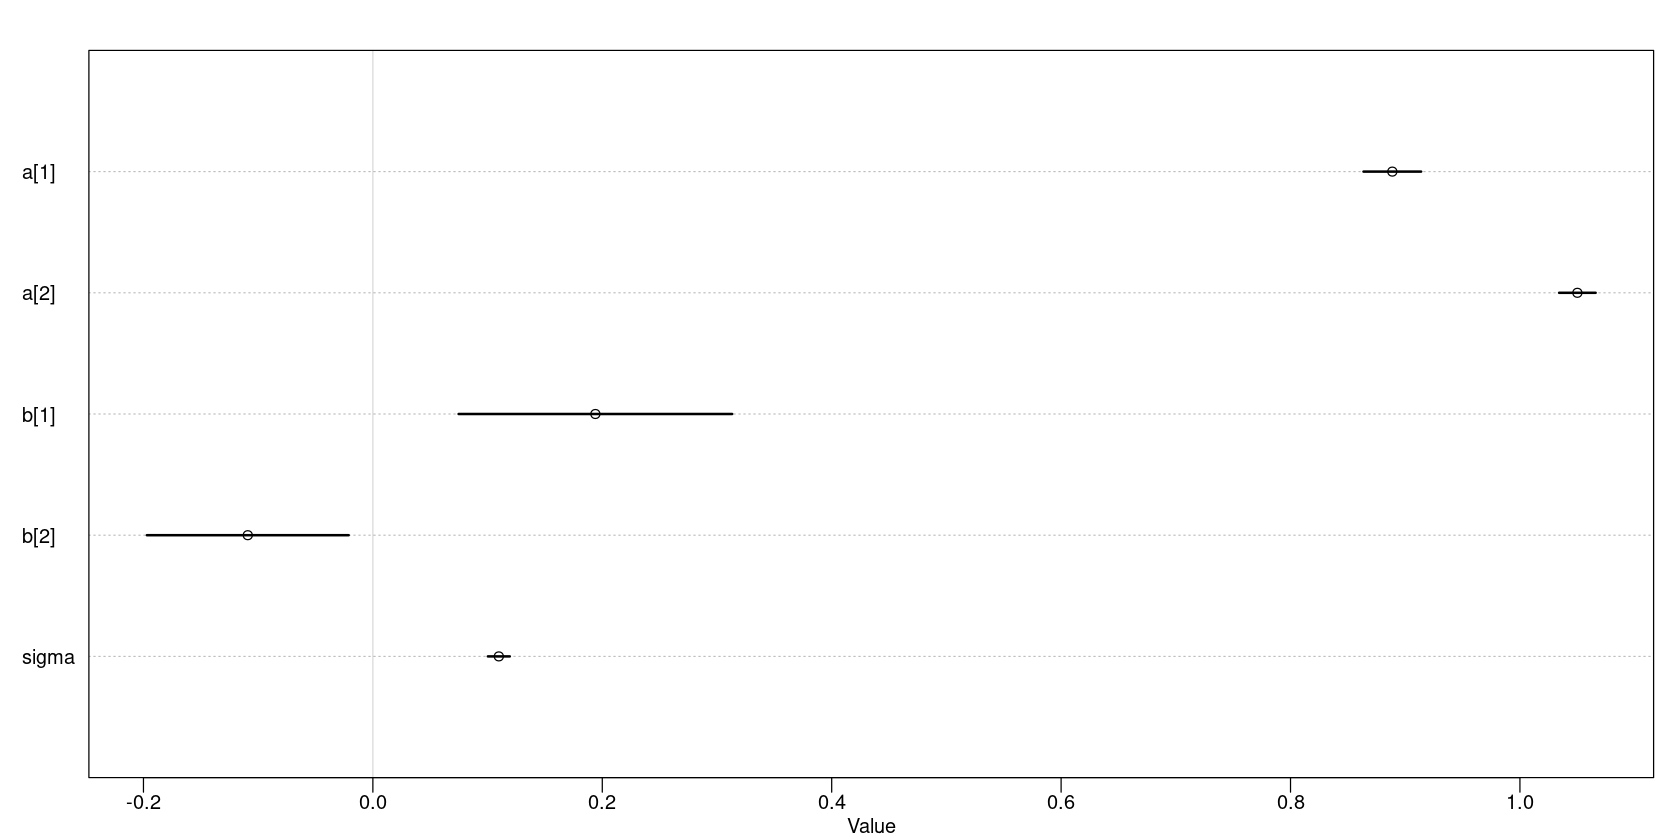

In [8]:
m8.3 <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dnorm(1, 0.3),
        sigma ~ dexp(1)
    ),
    data=dd
)
precis(m8.3, depth=2)
plot(precis(m8.3, depth=2))

### Preparation

Now we're going to fit the model using HMC. This means no more quadratic approximation to the posterior - instead, it will take on whatever shape it wants. There are two preprocessing steps:
1. Preprocess all transformed variables. This means that if we e.g. take the log of a variable, or square it, or whatever, we do that in the dataframe *before* we fit it. It's a waste of processing power to do the transformation in each step of HMC.
2. Make a new, trimmed-down data frame containing *only* the variables we need. This is not strictly necessary, but it prevents common issues (like an NA in an unused column causing **Stan** to refuse to run).

We've already pre-transformed the variables; new we just need to slim the data frame.

In [9]:
data_slim <- list(
    log_gdp_std = dd$log_gdp_std,
    rugged_std = dd$rugged_std,
    cid = as.integer(dd$cid)
)
str(data_slim)

List of 3
 $ log_gdp_std: num [1:170] 0.88 0.965 1.166 1.104 0.915 ...
 $ rugged_std : num [1:170] 0.138 0.553 0.124 0.125 0.433 ...
 $ cid        : int [1:170] 1 2 2 2 2 2 2 2 2 1 ...


It's better to use a `list` than a `data.frame` because in a data frame, all of the columns must have the same length. In other models (e.g. multilevel ones), it's OK for the variables to have different lengths.

### Sampling from the posterior

Now we can get samples from the posterior!

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.


,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.8882368,0.016053763,0.86316791,0.91296760,752.1304,0.9980003
a[2],1.0499470,0.009242085,1.03488680,1.06460435,625.9397,0.9980072
b[1],0.2002435,0.071848497,0.08232937,0.31398934,589.7900,0.9980332
b[2],-0.1101512,0.055206108,-0.19042892,-0.01586225,625.4812,1.0003306
sigma,0.1117481,0.006129151,0.10262657,0.12155522,454.5417,0.9981522


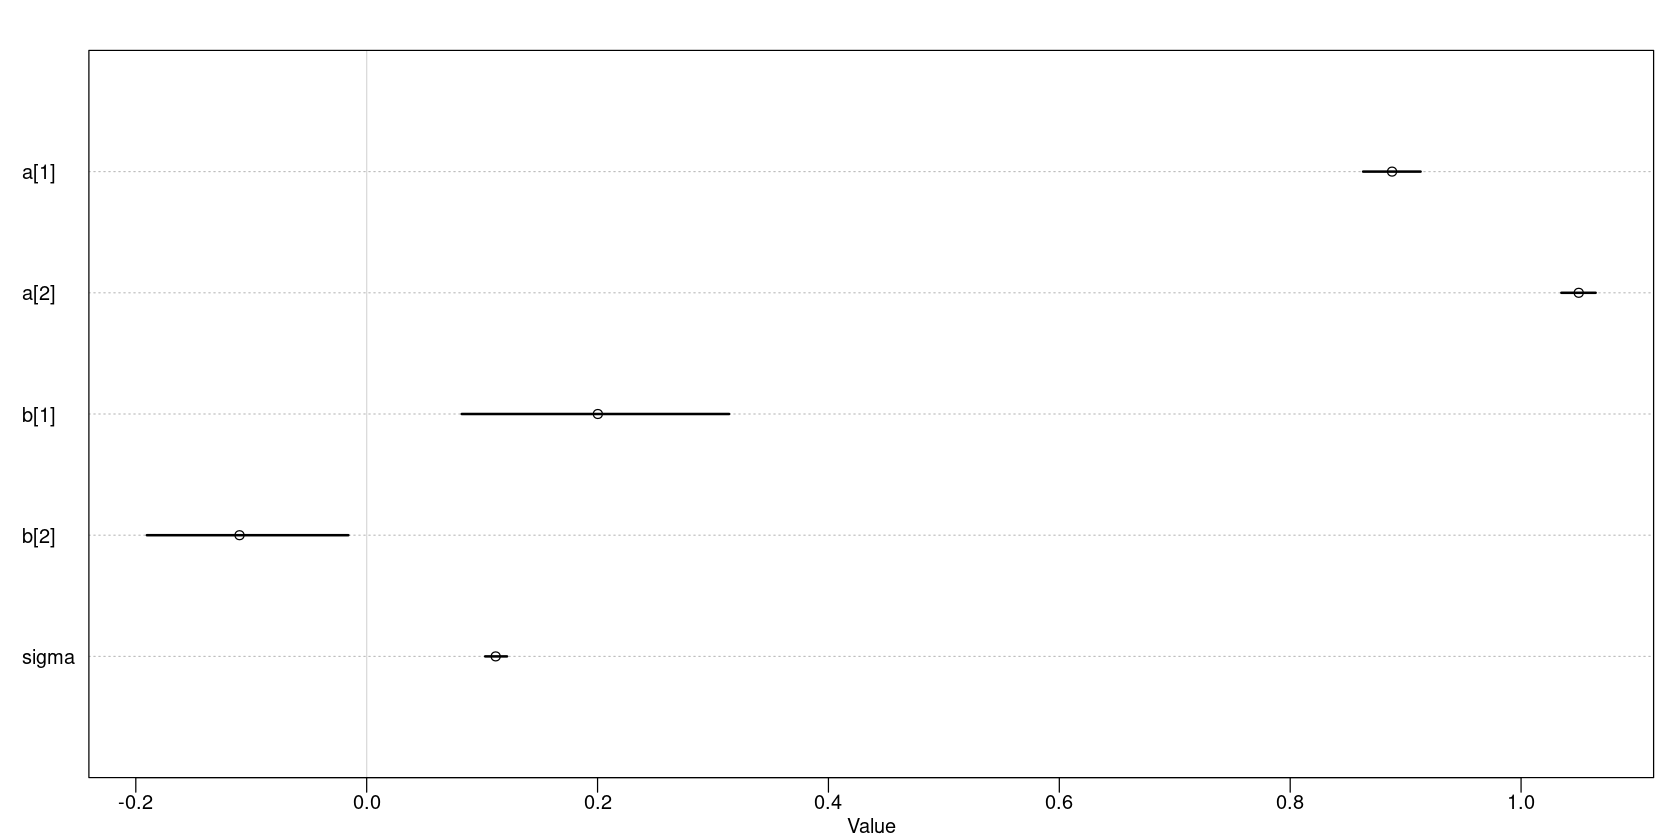

In [10]:
m9.1 <- ulam(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dnorm(1, 0.3),
        sigma ~ dexp(1)
    ),
    data=data_slim, chains=1
)
precis(m9.1, depth=2)
plot(precis(m9.1, depth=2))

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df31dcc69.stan', line 19, column 4 to column 39)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df31dcc69.stan', line 19, column 4 to column 39)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df31dcc69.stan', line 19, column 4 to column 39)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df31dcc69.stan', line 19, column 4 to column 39)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 0.6 seconds.



,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.8887568,0.015460680,0.86392436,0.91334494,2753.300,0.9993237
a[2],1.0500996,0.009782294,1.03460890,1.06546165,3228.385,0.9993800
b[1],0.1962327,0.074234885,0.08159196,0.31714376,2676.339,0.9993008
b[2],-0.1071516,0.057595068,-0.19882162,-0.01356533,2319.162,1.0029171
sigma,0.1119501,0.006082891,0.10264778,0.12229720,2638.681,0.9991328


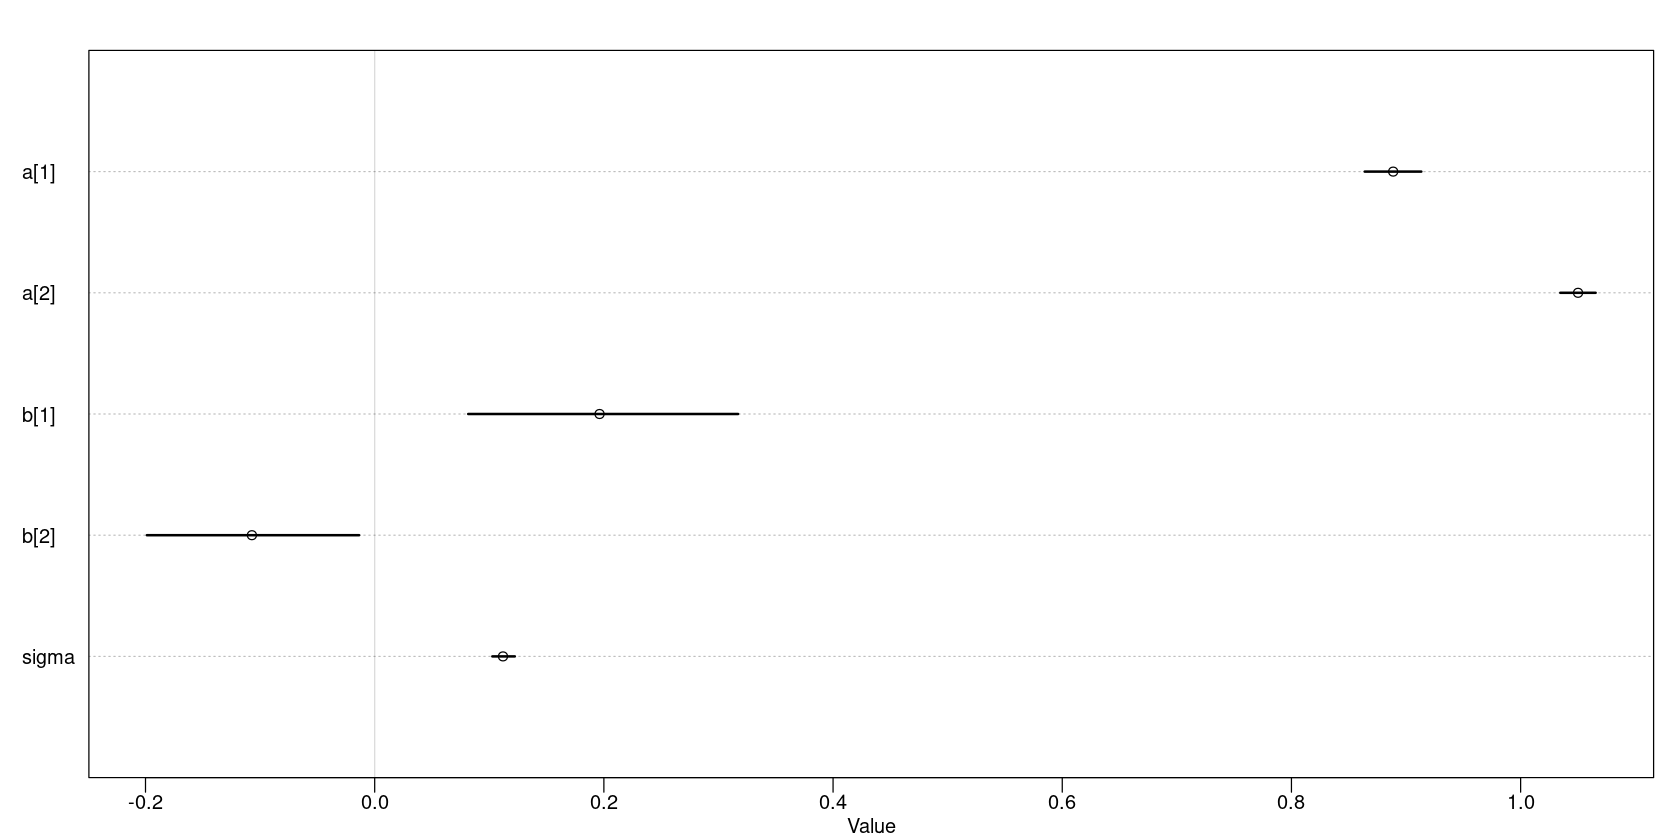

In [11]:
# Same idea, but more efficient - use 4 chains and 4 cores to do this
m9.1 <- ulam(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dnorm(1, 0.3),
        sigma ~ dexp(1)
    ),
    data=data_slim, chains=4, cores=4
)
precis(m9.1, depth=2)
plot(precis(m9.1, depth=2))

In [12]:
precis(m9.1, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.8887568,0.015460680,0.86392436,0.91334494,2753.300,0.9993237
a[2],1.0500996,0.009782294,1.03460890,1.06546165,3228.385,0.9993800
b[1],0.1962327,0.074234885,0.08159196,0.31714376,2676.339,0.9993008
b[2],-0.1071516,0.057595068,-0.19882162,-0.01356533,2319.162,1.0029171
sigma,0.1119501,0.006082891,0.10264778,0.12229720,2638.681,0.9991328


Note the two new columns:
- `n_eff` is an estimate of the number of independent samples (note that it can be larger than the actual number of samples because of the effectiveness of HMC)
- `Rhat4` is an indicator of the convergence of the chains. It should approach 1 from above if all is well.

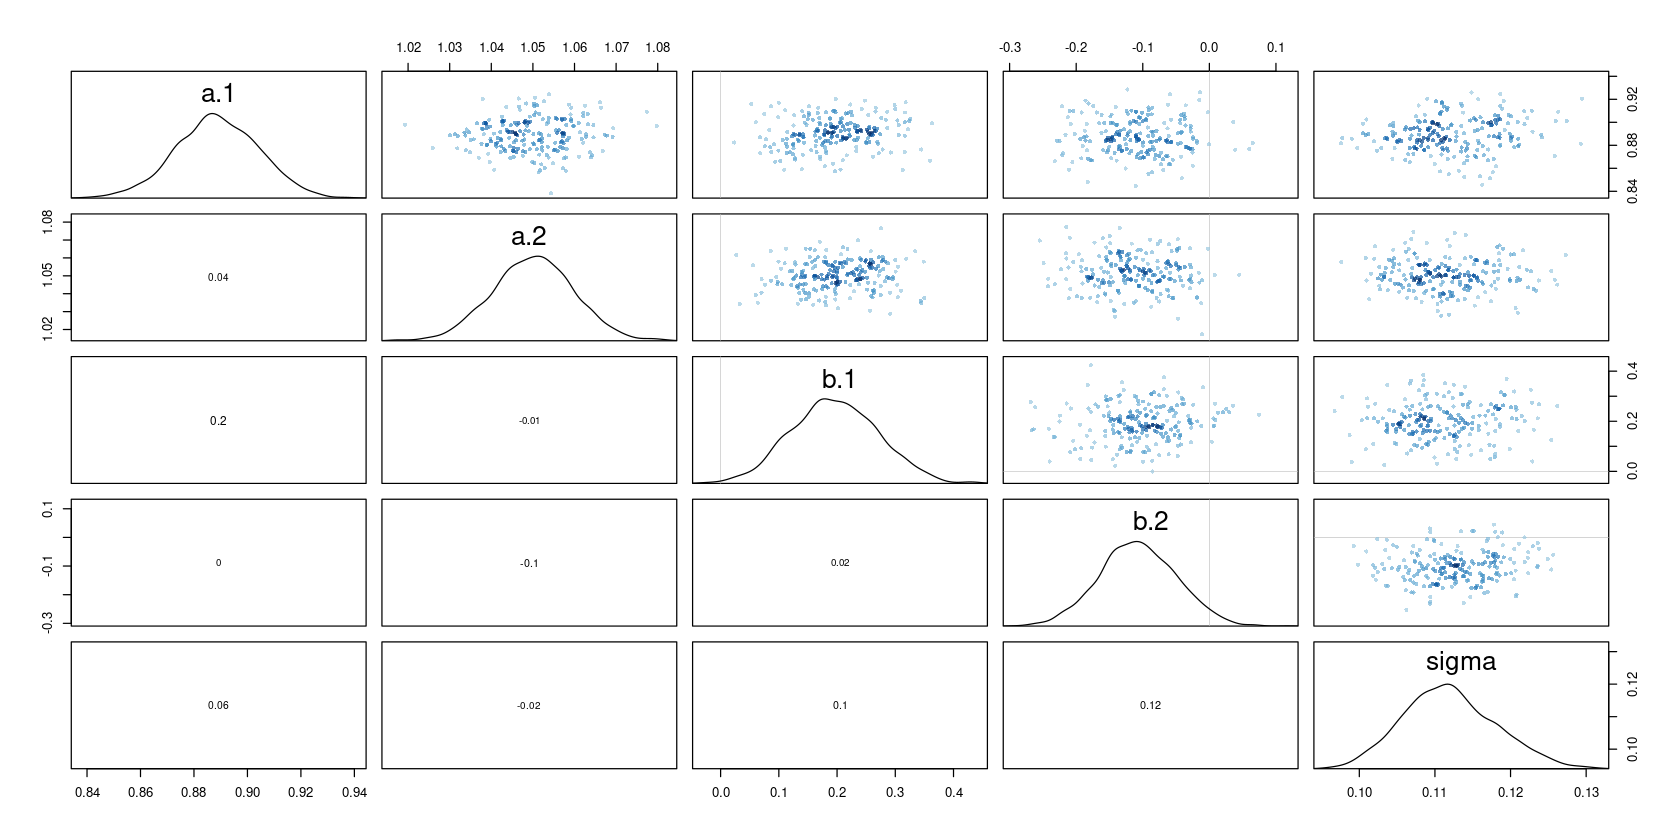

In [13]:
pairs(m9.1)

So we can se that the posteriors for all of the parameters are pretty Gaussian. That's good because so far we've been using a quadratic approximation!

### Checked the chain
If the Markov chain is correctly defined, then it will eventually converge to the correct posterior. However, some posteriors are hard to explore, and the convergence time can be very, very long. One advantage of **HMC** is that it will tell us when things are going wrong, while **Metropolis**, &c. will not - they'll just silently fail.

One way that can be used to spot problems is the **Trace plot**. This traces the path of the samples with lines connecting them. It's King Markov's path through the islands. Let's look at a healthy chain:

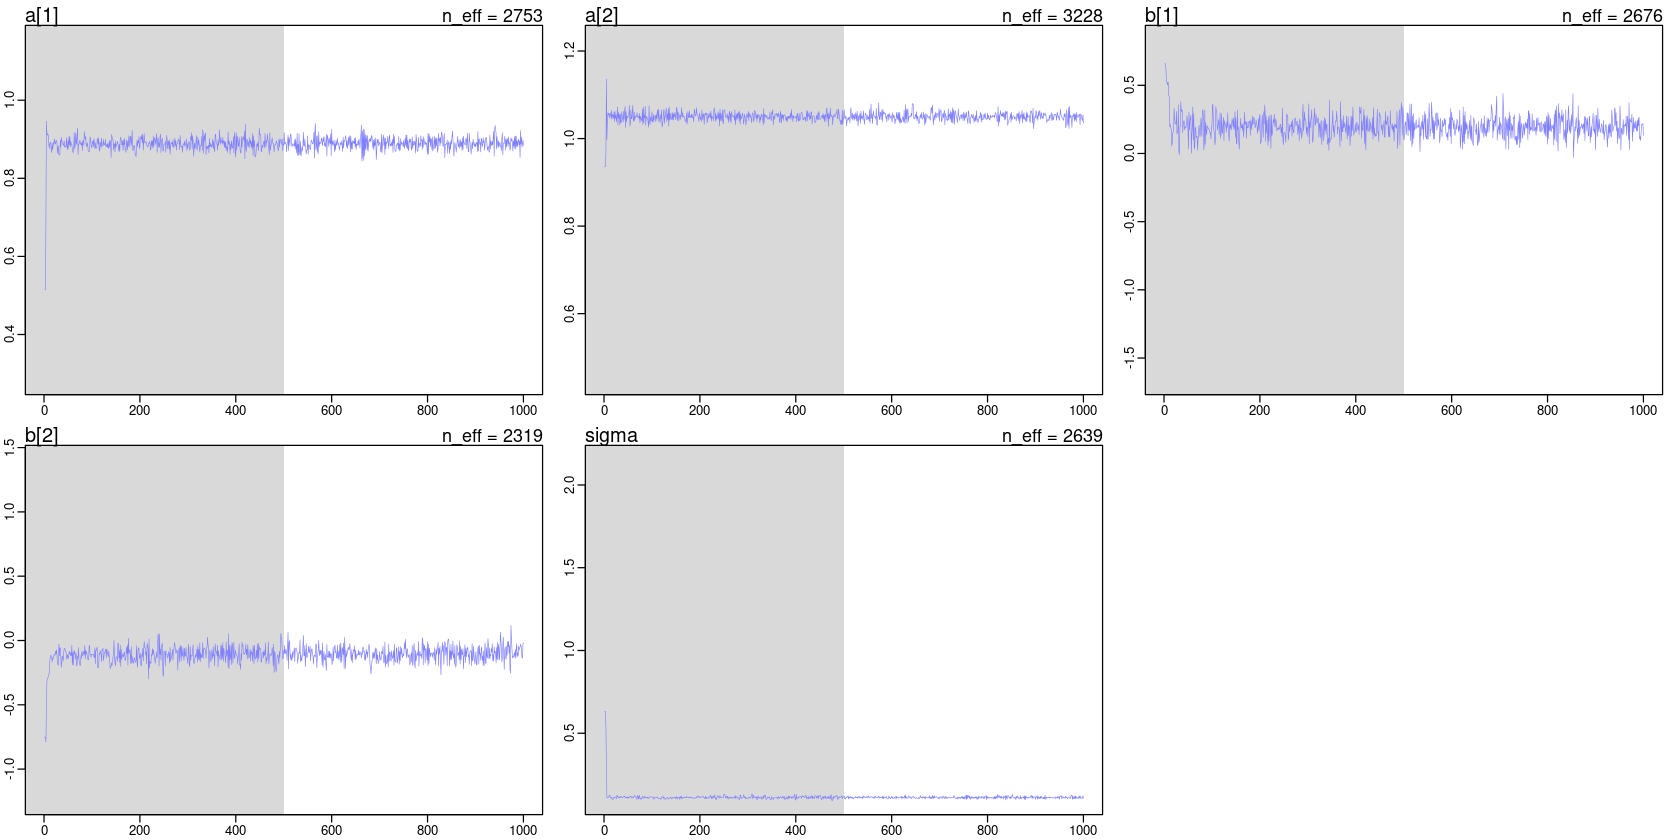

In [14]:
traceplot(m9.1, chains=1) # (just the first chain)

The samples in the grey region are the *adaptation samples*. These are used by **HMC** to learn how to better explore the posterior and are unreliable for inference (they are usually discarded).

How do we know that the samples are good? Typically we look for three things:
1. Stationarity: The samples should stay in the high-probability region of the posterior. Another way of thinking about this is that the mean of the samples should be stable from beginning to end.
1. Good mixing: The samples shouldn't slowly wander, but should rapidly explore the full region.
1. Convergence: Multiple independent chains stick around the same region of high probability

While trace plots are good for this, when you plot multiple of them then it can get confusing. Another way of visualizing the chains is a plot of the distribution of the ranked samples, a **Trace Rank Plot** or **Trank Plot**. The way that we create this is to rank all the samples from smallest to largest. The smallest gets rank 1 and the largest gets a rank of the number of total samples across all chains. Then draw a histogram. If the chains are exploring the same space efficiently, the histograms should be largely overlapping.

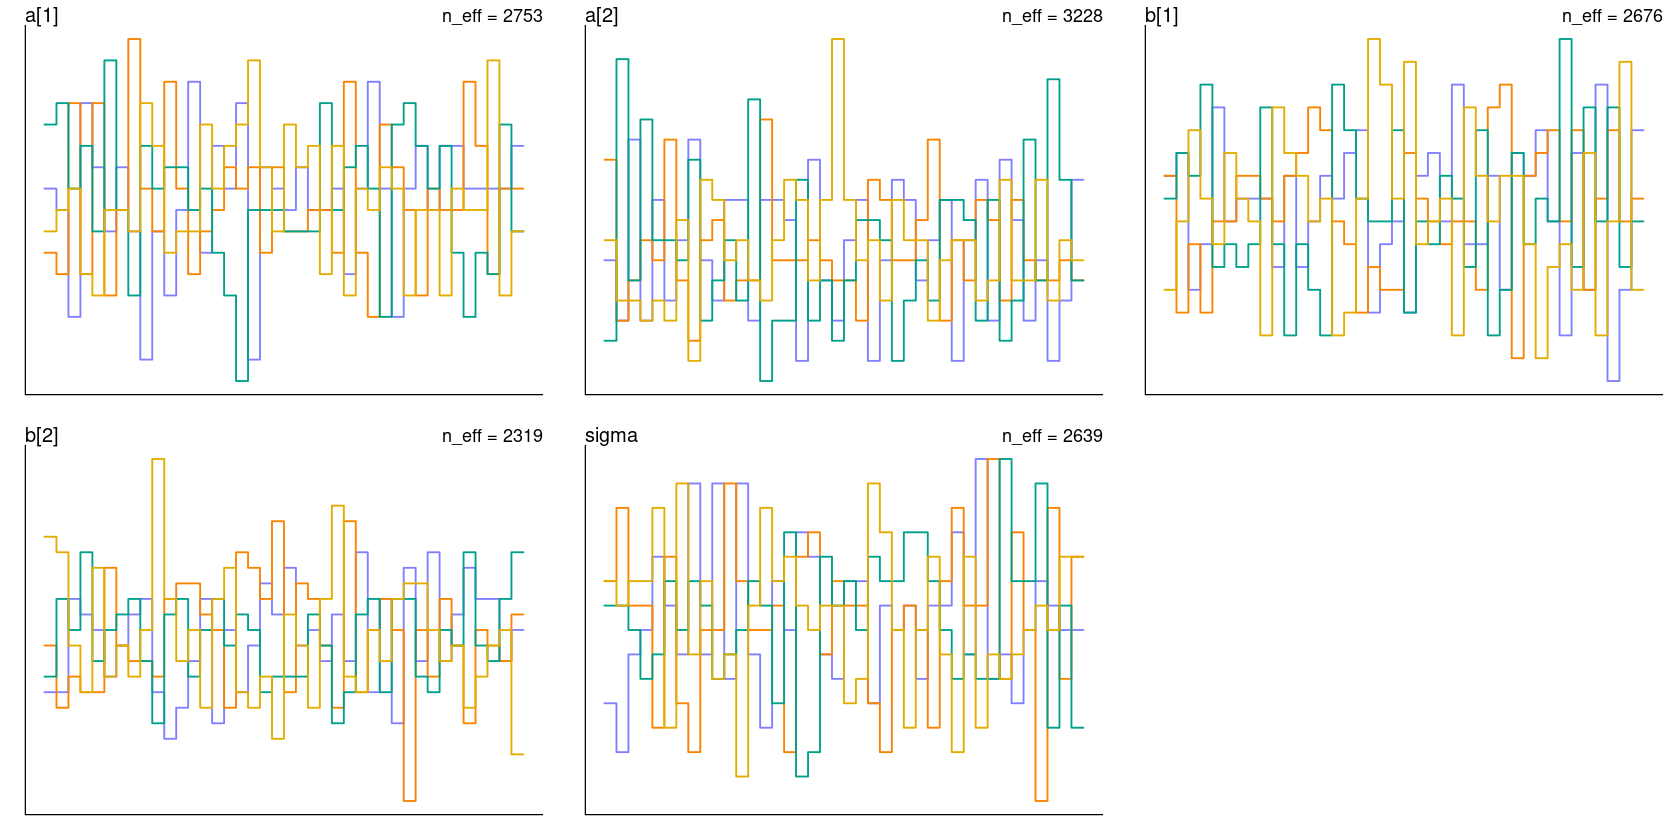

In [15]:
trankplot(m9.1)

## Care and feeding of your Markov chain

Let's look at some ways that it can go wrong!

### How many samples do you need?

You can control the number of samples using the `iter` and `warmup` parameters. How many do you need? First of all, it's the *effective* sample number you care about, not the raw one. Markov chains are typically **autocorrelated** - the previous value is correlated with the current one. This happens when the space is explored slowly, but it does reduce the effective sample number. 

The other thing is that it depends on what you care about! If you just care about the posterior mean, then you only need a few samples - even a few hundred will do. On the other hand if you care about the details of long-tail behaviour (99th percentile, e.g.) then you will need a much larger number of samples. If you have too few, **Stan** will warn you about *tail ESS*, the effective sample size in the tails of the distribution. If you see that warning, increasing the sample size almost always helps.

Note that warmup is not burn in (something that other algorithms, e.g. **Metropolis**, use). Warmup samples are never going to be representative of the posterior - that's not what they are there for.

### How many chains do you need?

1. When first debugging a model, use a single chain - it'll be easier to spot things going wrong. Also, some error messages only show when you run with only one chain.
1. When deciding whether a model is valid, use more than one chain
1. For inference, you really only need on chain, but it's fine to use more.

### Taming a wild chain

One common problem with some posteriors is that there is a broad, flat region of posterior density. This can result in a wildly wandering chain. Let's look at a simple example.

In [16]:
y <- c(-1, 1)
set.seed(11)
m9.2 <- ulam(
    alist(
        y ~ dnorm(mu, sigma),
        mu <- alpha,
        alpha ~ dnorm(0, 1000),
        sigma ~ dexp(0.0001)
    ),
    data=list(y=y),
    chains=3
)

Running MCMC with 3 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

See https://mc-stan.org/misc/warnings for details.




In [17]:
precis(m9.2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
alpha,-2.060421,347.3349,-475.737270,410.9988,57.82500,1.058860
sigma,545.855600,1684.5450,0.839904,2096.9688,43.47885,1.038526


That can't be right! The mean of -1 and 1 is 0, so we expect alpha to be around 0. Instead it is highly negative with a ridiculously wide standard deviation. Note also that the **Stan** code produced a warning about *transitions ending with a divergence* - that's bad!

We can use **Stan**'s `pairs` method to examine the fit - it will colour divergent transitions in red.

Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”
Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”
Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”


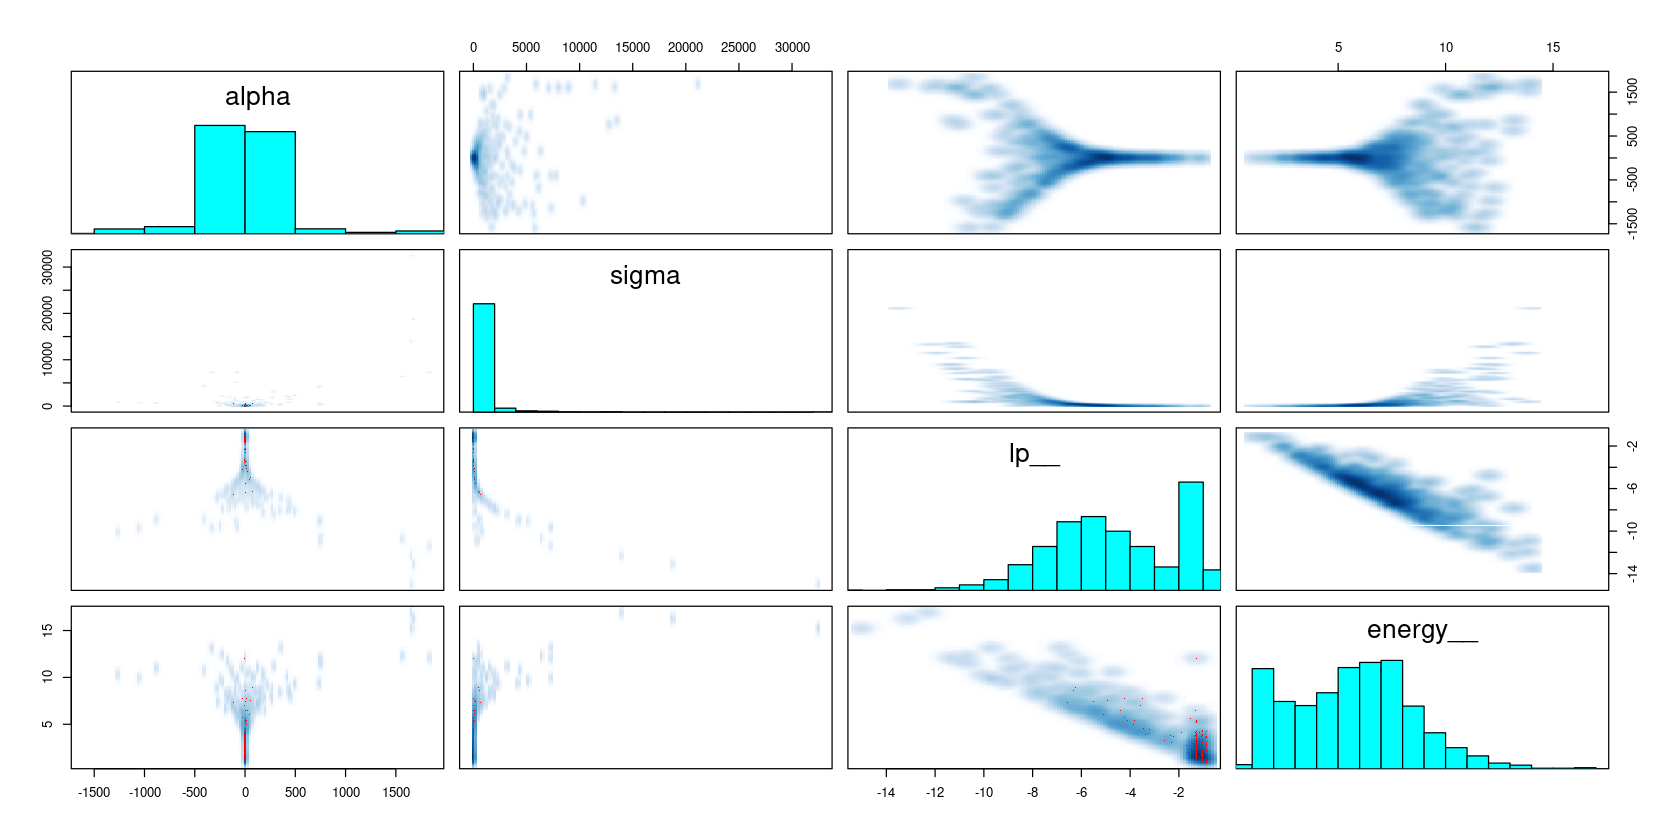

In [18]:
pairs(m9.2@stanfit)

Even without the red transitions, the shape of the posterior should be concerning.

Now let's look at the trace plot:

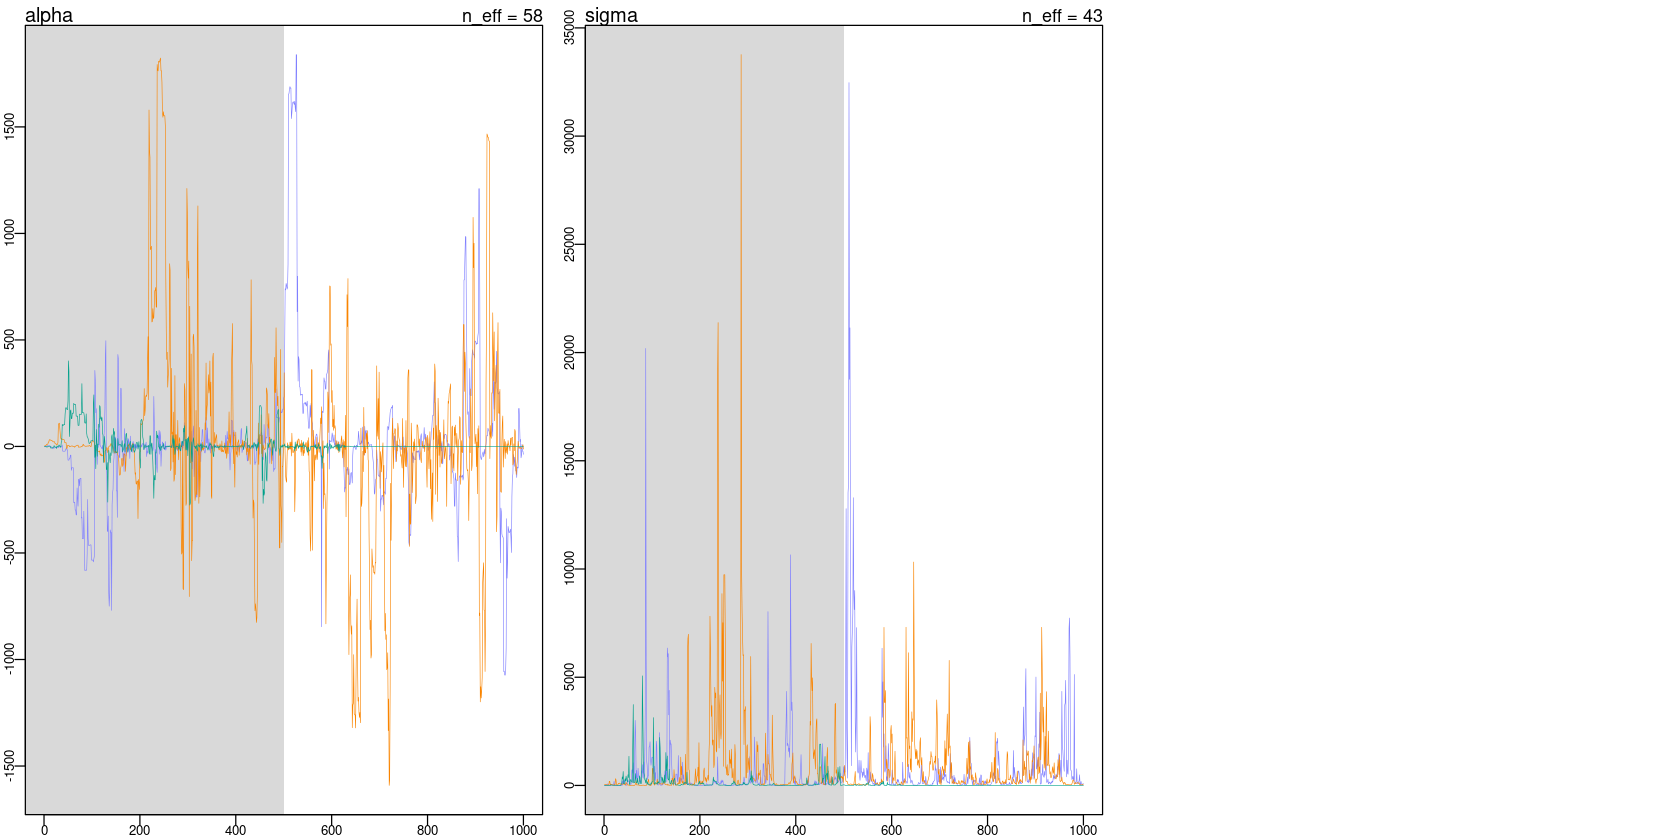

In [19]:
traceplot(m9.2)

This is not good! Note that the values are very spiky, going off to extreme values.

We can also look at the **Trank Plot**:

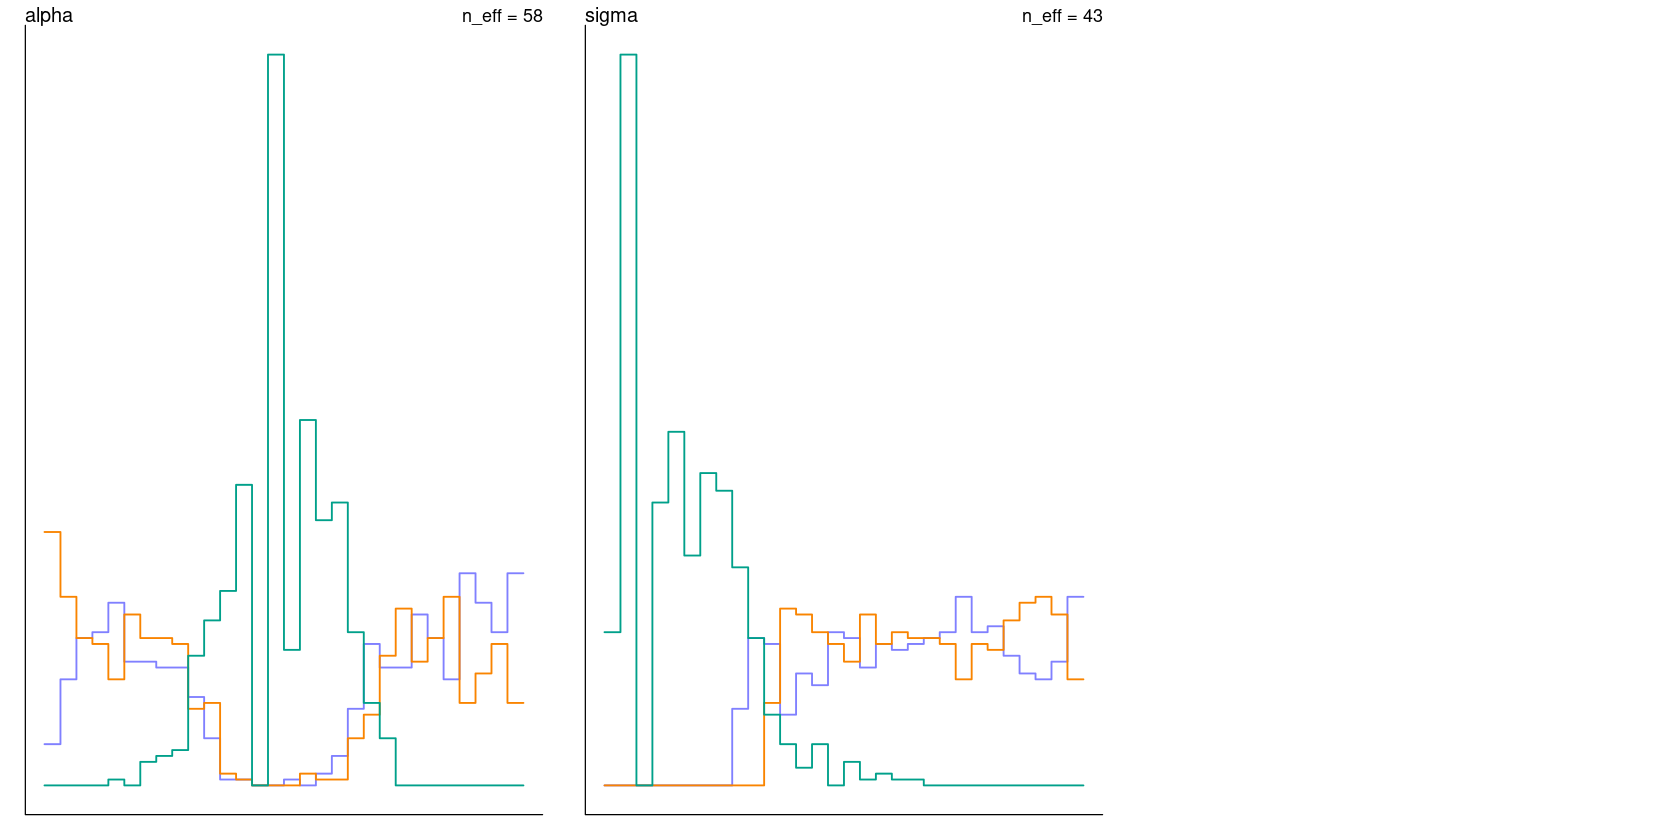

In [20]:
trankplot(m9.2)

Here, note that the histograms spend a significant amount of time with one above / below the other.

The reason that these chains do such a bad job converging is because there is very little data (two points) and the priors are flat. That means that basically all values are very plausible, and so the chains spend a lot of time just wandering around. We can fix it in this case by providing even minimally informative priors:

In [21]:
# adding weakly informative priors to alpha and sigma
set.seed(11)
m9.3 <- ulam(
    alist(
        y ~ dnorm(mu, sigma),
        mu <- alpha,
        alpha ~ dnorm(1, 10),
        sigma ~ dexp(1)
    ),
    data=list(y=y),
    chains=3
)
precis(m9.3)

Running MCMC with 3 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
alpha,0.06502573,1.0896645,-1.5337209,1.735513,491.0051,1.007427
sigma,1.50738494,0.8362786,0.6736518,3.079862,371.8593,1.003969


These values seem more plausible. We can also look at the trace and tranks plots, as well as a plot of the prior vs. posterior.

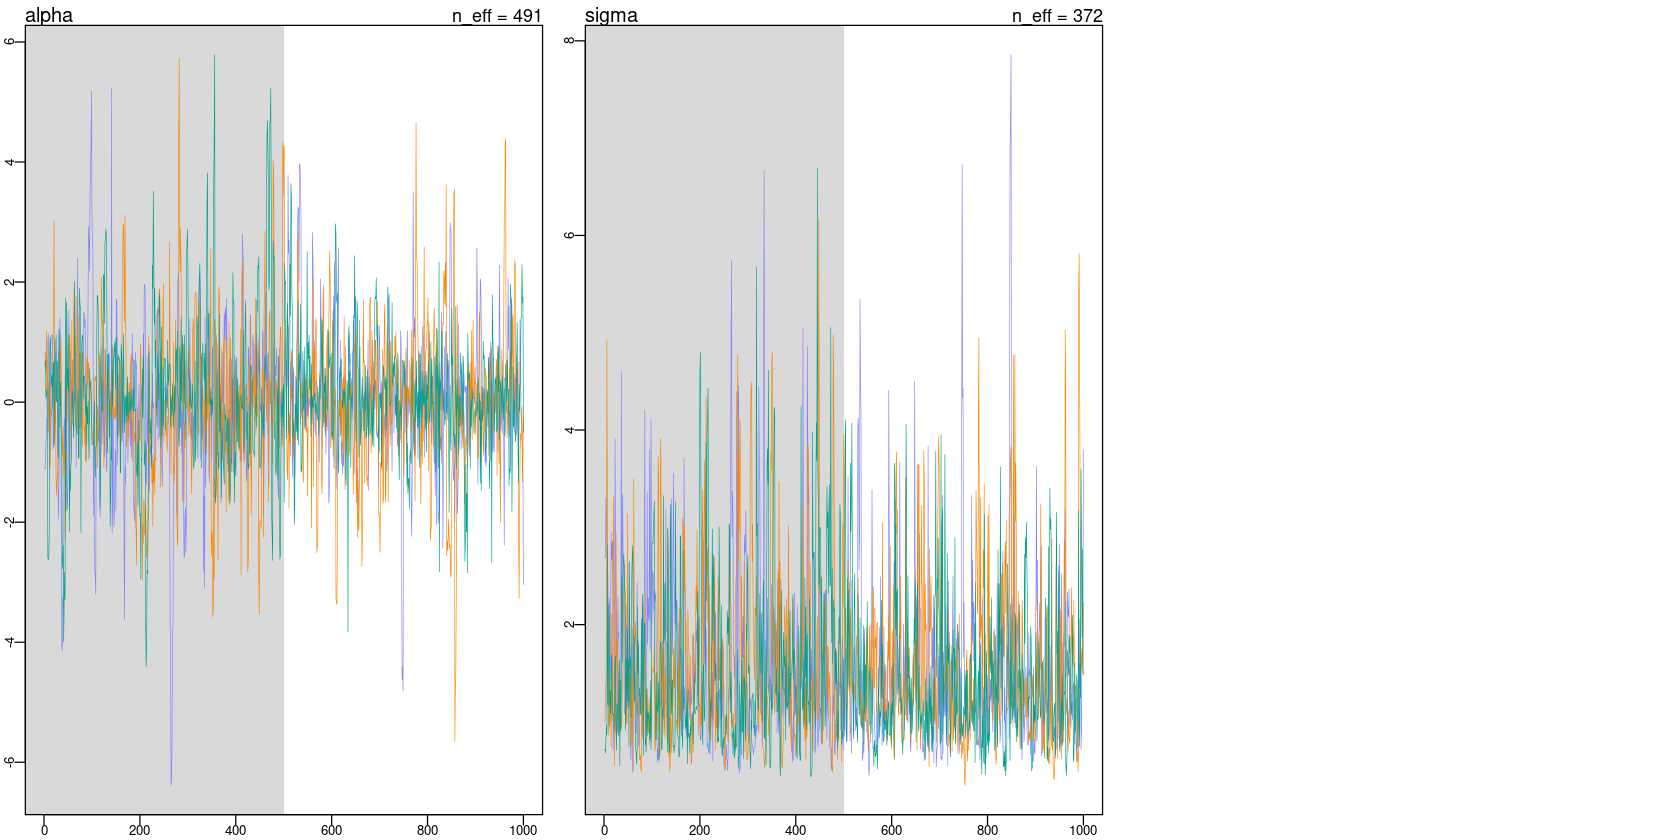

In [22]:
traceplot(m9.3)

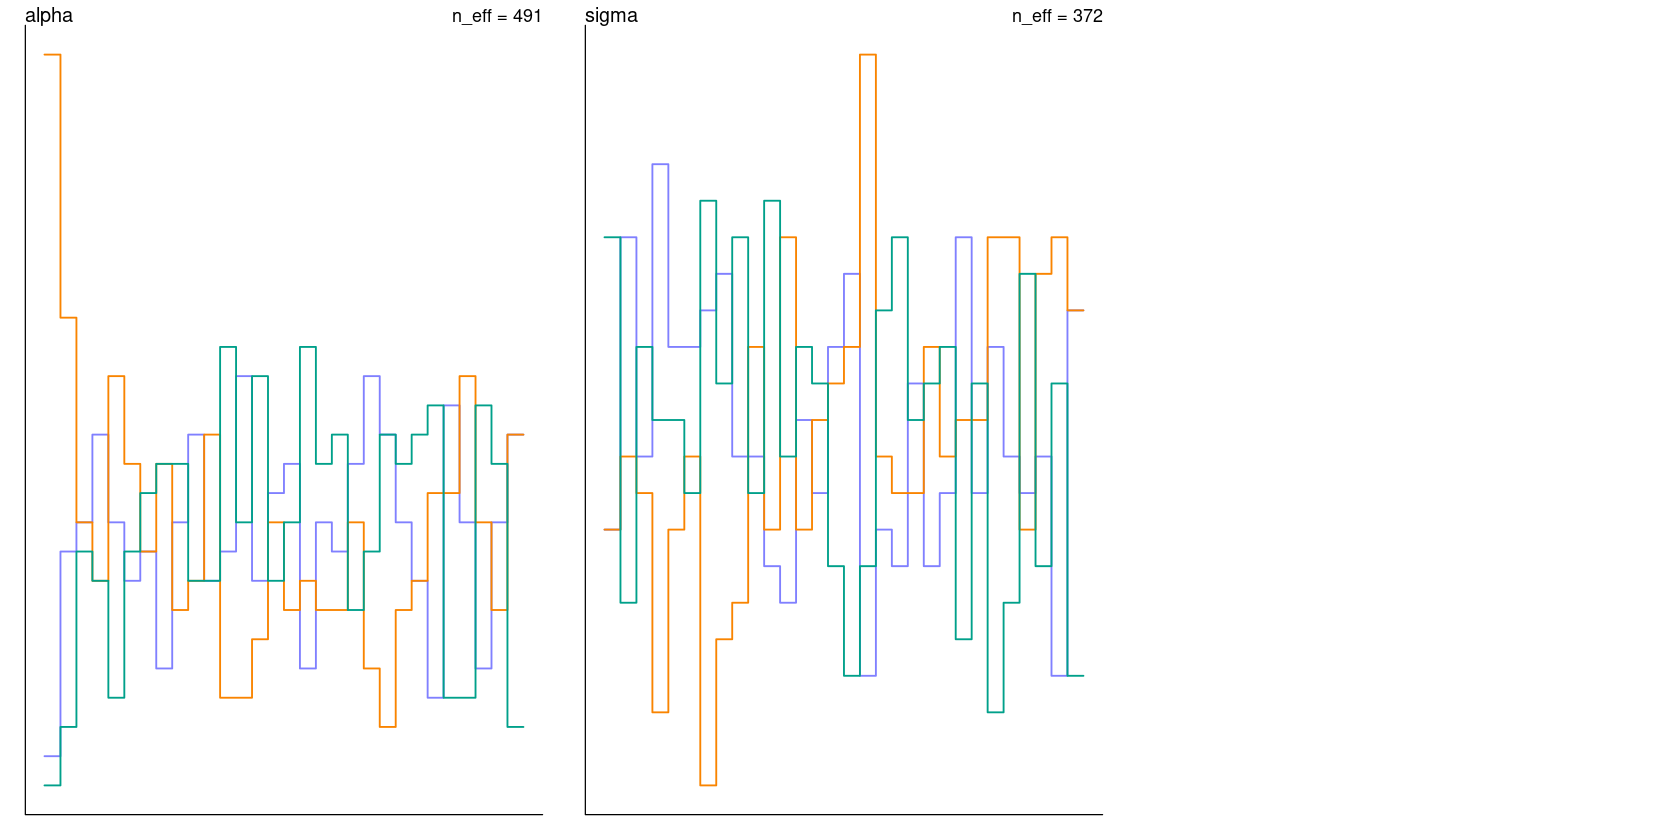

In [23]:
trankplot(m9.3)

In [24]:
samples <- extract.samples(m9.3, n=10000)
priors <- extract.prior(m9.3, n=10000)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:     1 / 20000 [  0%]  (Warmup) 
Chain 1 Iteration:   100 / 20000 [  0%]  (Warmup) 
Chain 1 Iteration:   200 / 20000 [  1%]  (Warmup) 
Chain 1 Iteration:   300 / 20000 [  1%]  (Warmup) 
Chain 1 Iteration:   400 / 20000 [  2%]  (Warmup) 
Chain 1 Iteration:   500 / 20000 [  2%]  (Warmup) 
Chain 1 Iteration:   600 / 20000 [  3%]  (Warmup) 
Chain 1 Iteration:   700 / 20000 [  3%]  (Warmup) 
Chain 1 Iteration:   800 / 20000 [  4%]  (Warmup) 
Chain 1 Iteration:   900 / 20000 [  4%]  (Warmup) 
Chain 1 Iteration:  1000 / 20000 [  5%]  (Warmup) 
Chain 1 Iteration:  1100 / 20000 [  5%]  (Warmup) 
Chain 1 Iteration:  1200 / 20000 [  6%]  (Warmup) 
Chain 1 Iteration:  1300 / 20000 [  6%]  (Warmup) 
Chain 1 Iteration:  1400 / 20000 [  7%]  (Warmup) 
Chain 1 Iteration:  1500 / 20000 [  7%]  (Warmup) 
Chain 1 Iteration:  1600 / 20000 [  8%]  (Warmup) 
Chain 1 Iteration:  1700 / 20000 [  8%]  (Warmup) 
Chain 1 Iteration:  1800

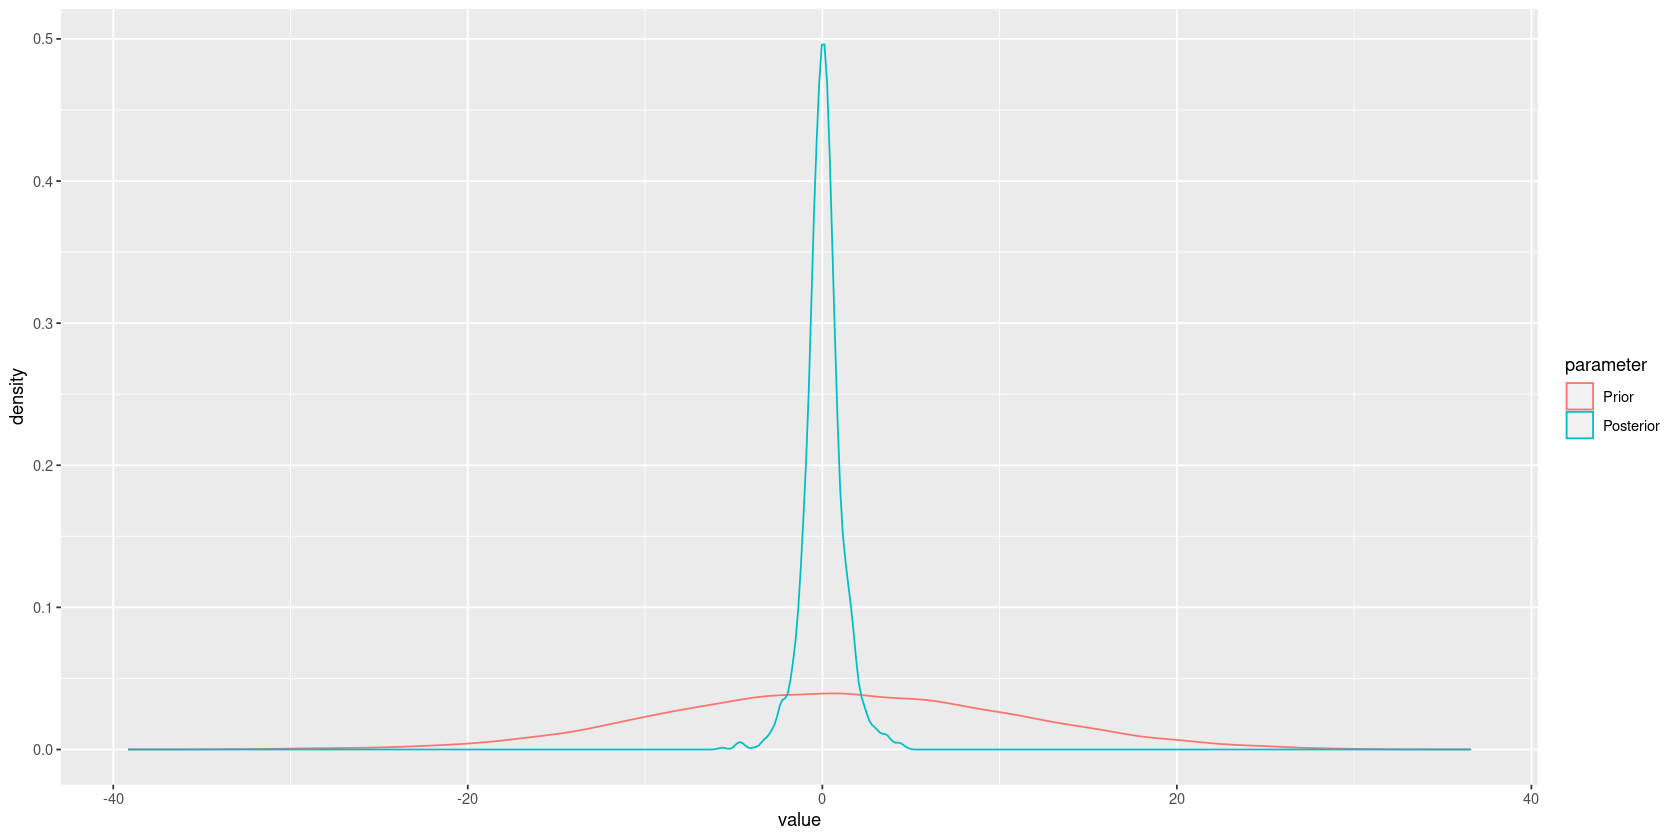

In [25]:
alpha_plot_df <- rbind(
    data.frame(value=priors$alpha, parameter=as.factor("Prior")),
    data.frame(value=samples$alpha, parameter=as.factor("Posterior"))
)
# alpha_plot_df
ggplot(alpha_plot_df, aes(x=value, colour=parameter)) +
    geom_density()

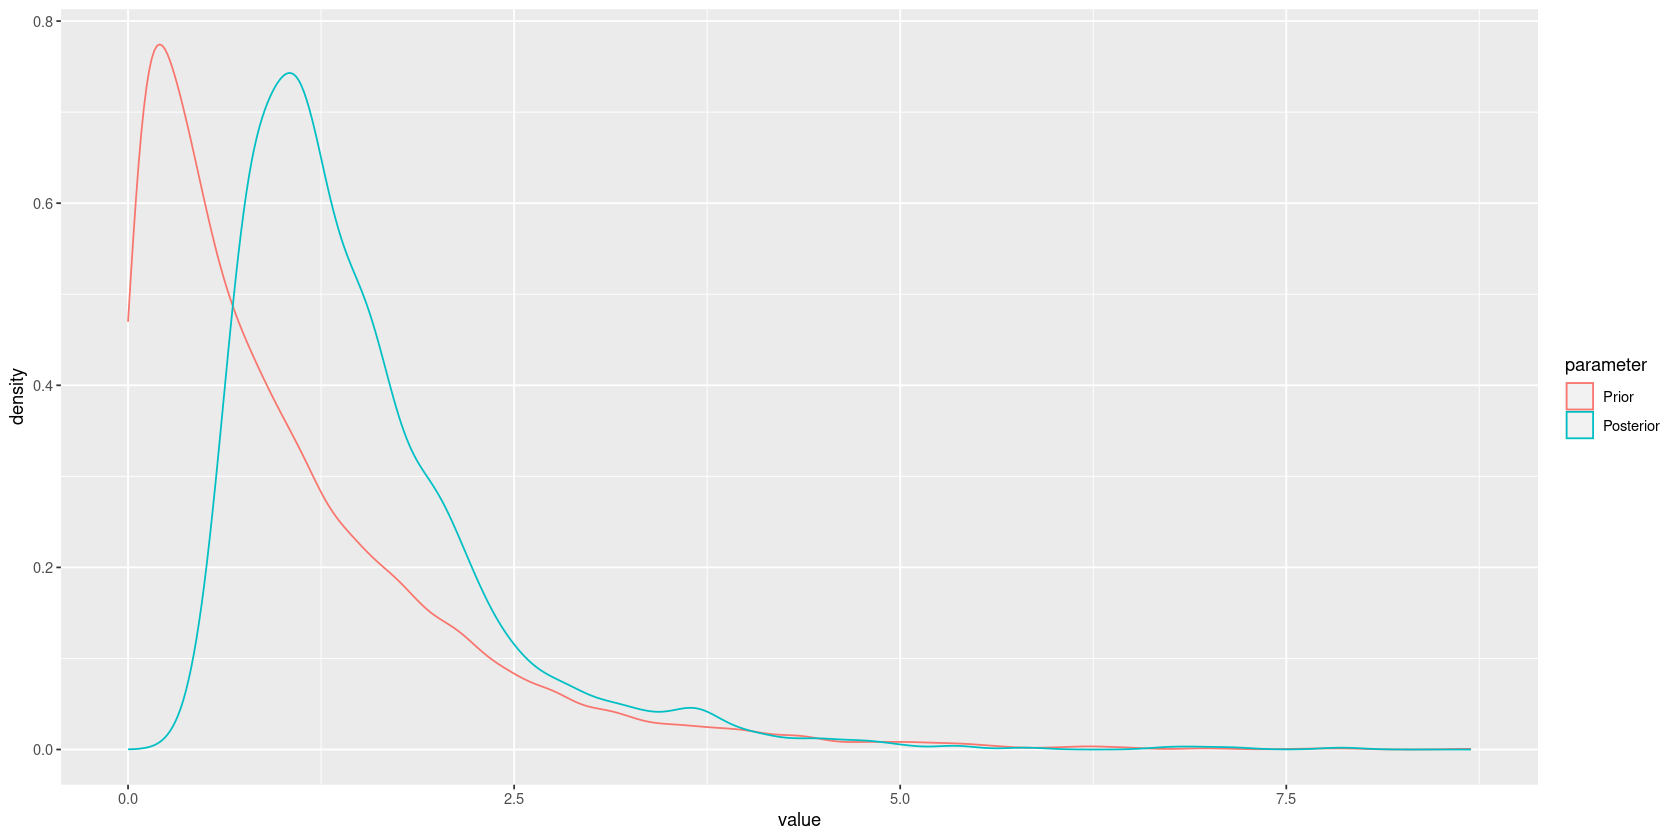

In [26]:
sigma_plot_df <- rbind(
    data.frame(value=priors$sigma, parameter=as.factor("Prior")),
    data.frame(value=samples$sigma, parameter=as.factor("Posterior"))
)
# alpha_plot_df
ggplot(sigma_plot_df, aes(x=value, colour=parameter)) +
    geom_density()

What happened here? The very subtle priors are providing a bit of a hint so that the extreme values are no loner exactly as plausible as the more intermediate ones. This gives a small nudge to the chains so that they end up in the right place.

Apparently lots of problematic chain just want a very weakly informative prior like this to prevent them going all over the place.

### Non-Identifiable Parameters

In **Chapter 6**, we looked at highly correlated predictors and the non-identifiable parameters they create. Here we'll see how we can identify them using some prior information and see how they behave badly in the model.

In [27]:
set.seed(41)

# initial data
y <- rnorm(100, mean=0, sd=1)

set.seed(384)
# here the sum a1 + a2 should be 0, but there's not enough information to give either of them specific values
m9.4 <- ulam(
    alist(
        y ~ dnorm(mu, sigma),
        mu <- a1 + a2,
        c(a1, a2) ~ dnorm(0, 1000),
        sigma ~ dexp(1)
    ),
    data=list(y=y),
    chains=4
)
precis(m9.4)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df3535ada1.stan', line 15, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.7 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df3535ada1.stan', line 15, column 4 to column 29)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.6 seconds.
Total execution time: 2.8 seconds.



See https://mc-stan.org/misc/warnings for details.




,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a2,272.991077,187.02635075,-55.1594790,565.438075,7.409435,1.545280
a1,-272.806281,187.02605892,-565.2485700,55.279714,7.408718,1.545295
sigma,1.028379,0.05795455,0.9407723,1.135787,65.290858,1.060688


These values are real bad - the means are about the same and on the opposite side of zero with huge standard deviations. Also the `n_eff` and `Rhat4` are really bad. Looking at the trace place, we see that they don't seem to be stationary and also don't seem to be mxing well.

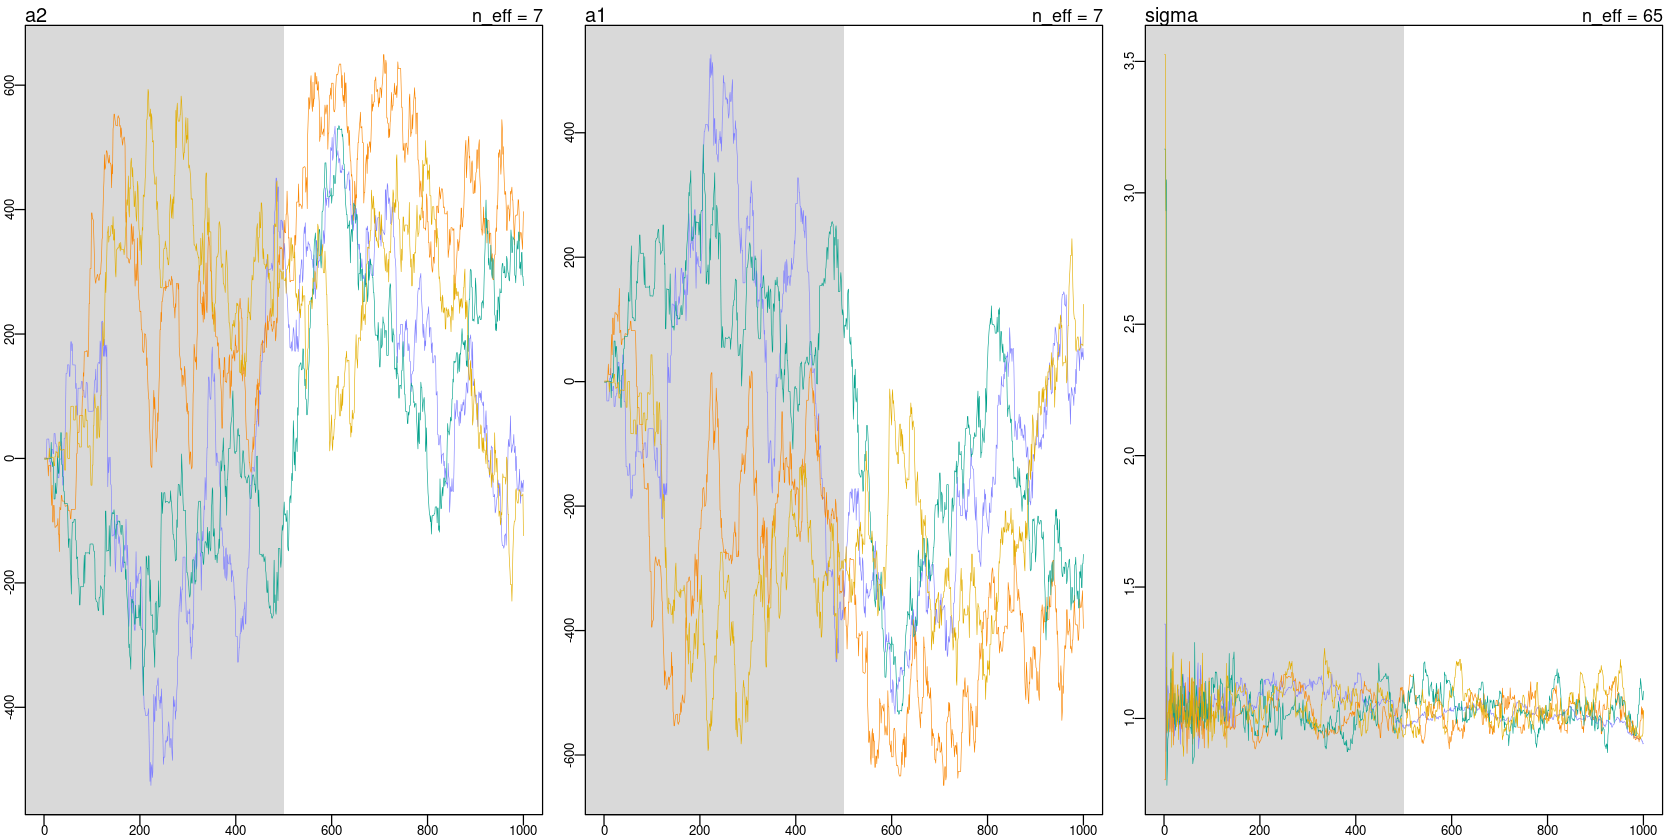

In [28]:
traceplot(m9.4)

In [29]:
# Now with weak regularizing priors
m9.5 <- ulam(
    alist(
        y ~ dnorm(mu, sigma),
        mu <- a1 + a2,
        c(a1, a2) ~ dnorm(0, 10),
        sigma ~ dexp(1)
    ),
    data=list(y=y),
    chains=4
)
precis(m9.5)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df76aacba7.stan', line 15, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.2 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.2 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chai

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a2,-0.3094809,6.84994487,-11.5319445,10.274811,629.9868,1.002312
a1,0.5045645,6.85156018,-10.0406925,11.714637,630.0262,1.002338
sigma,1.0406885,0.07554088,0.9262039,1.169552,675.1610,1.000228


This seems much more reasonable! The parameters are still non-identifiable, but at least their values are closer to what we expect. By looking at the trace plot, we see that it looks much better as well:

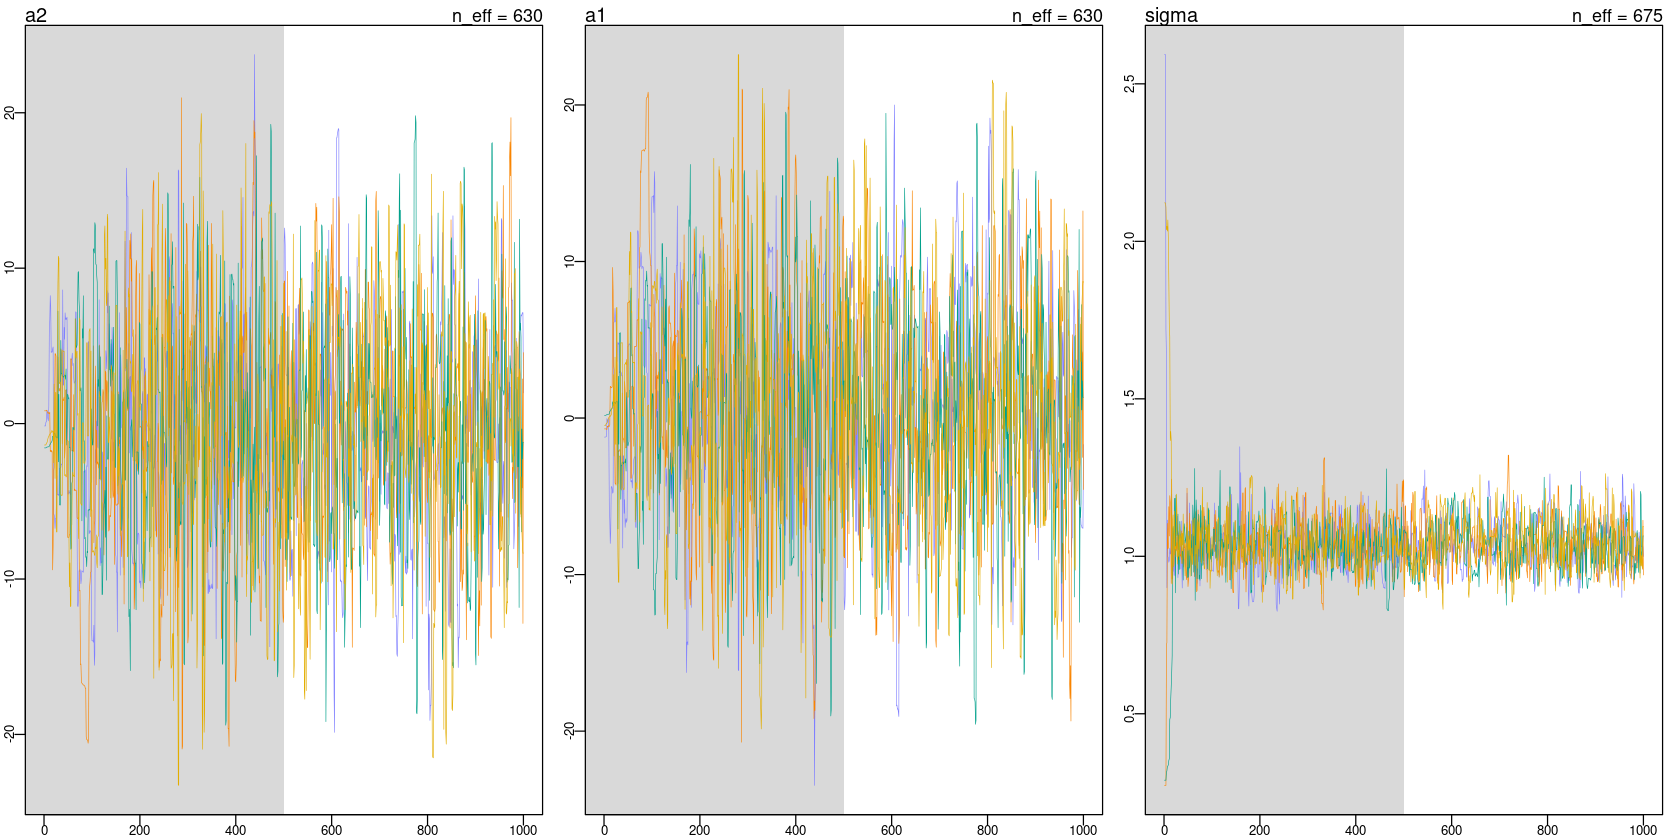

In [30]:
traceplot(m9.5)

# Practice

#### 9E1 Which of the following is a requirement of the simple Metropolis algorithm?
1. The parameters must be discrete
1. The likelihood function must be Gaussian
1. The proposal distribution must be symmetric

From the chapter, the proposal distribution must be symmetric.

#### 9E2 Gibbs sampling is more efficient than the Metropolis algorithm. How does it achieve this extra efficiency? Are there any limitations to the Gibbs sampling strategy?

From the chapter, the extra efficiency is gained from using conjugate priors to make better proposals for the next step to evaluate depending on the current step. This also means that the proposals need to be able to be asymmetric.

There are certainly some limitations to using the Gibbs sampler. 
1. Sometimes you don't want to or can't use conjugate priors.
1. With problems involving lots of parameters (higher-dimensional problems), the exploration of the space can get very very slow and inefficient as the algorithm gets stuck in high-probability regions far from the mode.

#### 9E3 Which sort of parameters can Hamiltonian Monte Carlo not handle? Explain why.

HMC cannot handle discrete parameters because it uses the ideas of position and momentum (both continuous) to explore the parameter space; this doesn't work if the parameter space is discrete.

#### 9E4 Explain the difference between the effective number of samples, `n_eff` as calculatd by **Stan**, and the actual number of samples.

The actual number of samples is the literal amount of samples that were used to compute the approximation. The *effective* number of samples `n_eff` is an estimate of the number of independent samples you would need to get the same level of accuracy.

#### 9E5 Which values should `Rhat` approach when a chain is sampling the posterior distribution correctly?

`Rhat` should approach 1 from above.

#### 9E6 Sketch a good trace plot for a Markov chain, one that is effectively sampling from the poertior distribution. What is good about its shape? Then sketch a trace plt for a malfunctioning Markov chain. what about its shape indicates malfunction?

A good trace plot should be stationary (have roughly the same mean throughout) and wiggle erratically about this mean.

#### 9E7 Repeat the above, but for a trace rank plot.

A good trace rank plot should show that the histograms for the different chains should be very similar to each other; as a consequence they should be constantly switching position (which one is above and which below).

#### 9M1 Re-estimate the terrain ruggedness model from the chapter, but now using a uniform prior for the standard deviation `sigma`. The uniform prior should be `dunif(0, 1)`. Use `ulam` to estimate the posterior. Does the different prior have any detectible influence on the posterior distribution of `sigma`? Why or why not?

In [31]:
data(rugged)
d <- rugged[!is.na(rugged$rgdppc_2000),]
d$log_gdp <- log(d$rgdppc_2000)
dd <- d[ complete.cases(d$rgdppc_2000),]
dd$log_gdp_std <- dd$log_gdp / mean(dd$log_gdp)
dd$rugged_std <- dd$rugged / max(dd$rugged)
dd$cid <- ifelse(dd$cont_africa==1, 1, 2)

data_slim <- list(
    log_gdp_std = dd$log_gdp_std,
    rugged_std = dd$rugged_std,
    cid = as.integer(dd$cid)
)

m9.1 <- ulam(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dnorm(1, 0.3),
        sigma ~ dexp(1)
    ),
    data=data_slim, chains=4, cores=4
)

m9.1_uniform <- ulam(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dnorm(1, 0.3),
        sigma ~ dunif(0, 1)
    ),
    data=data_slim, chains=4, cores=4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df4675769a.stan', line 19, column 4 to column 39)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df4675769a.stan', line 19, column 4 to column 39)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 finished in 0.0 seconds.
Chain 2 finished in 0.0 seconds.
Chain 3 finished in 0.0 seconds.
Chain 4 finished in 0.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.0 seconds.
Total execution time: 0.6 seconds.

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Ch

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df185ffb1f.stan', line 19, column 4 to column 39)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 

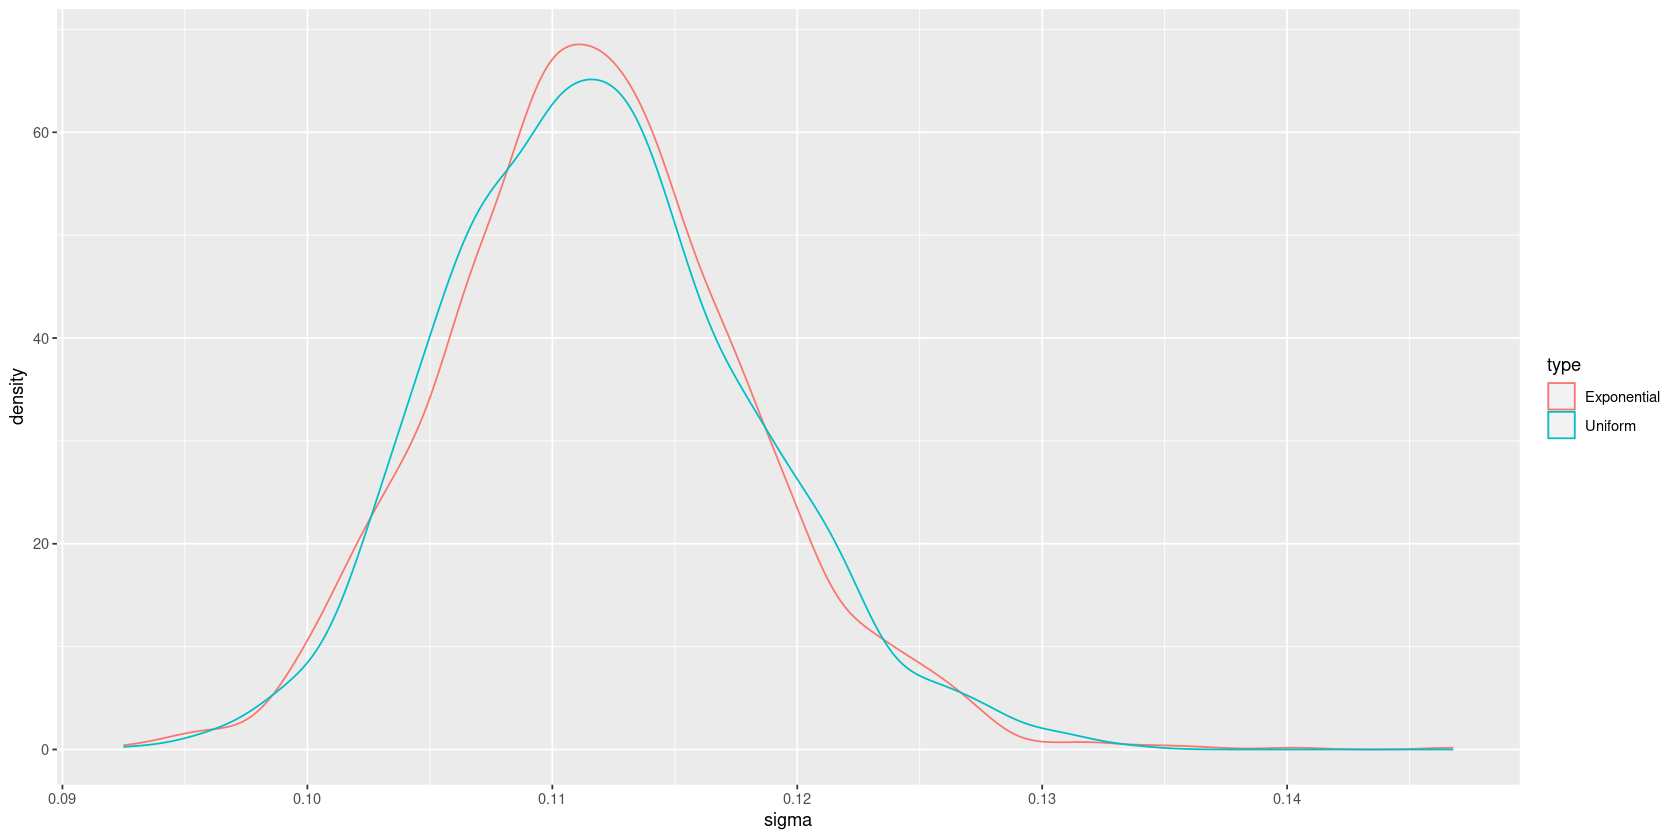

In [32]:
regular_posterior <- extract.samples(m9.1)
uniform_posterior <- extract.samples(m9.1_uniform)

plot_df <- rbind(
    data.frame(sigma=regular_posterior$sigma, type="Exponential"),
    data.frame(sigma=uniform_posterior$sigma, type="Uniform")
)

ggplot(plot_df, aes(x=sigma, colour=type)) +
    geom_density()

No real difference - the data is overwhelming the priors.

#### 9M2 Modify the terrain ruggedness model again. this time, change the prior for `b[cid]` to `dexp(0.3)`. what does this do to the posterior distribution? Can you explain it?

In [53]:
data(rugged)
d <- rugged[!is.na(rugged$rgdppc_2000),]
d$log_gdp <- log(d$rgdppc_2000)
dd <- d[ complete.cases(d$rgdppc_2000),]
dd$log_gdp_std <- dd$log_gdp / mean(dd$log_gdp)
dd$rugged_std <- dd$rugged / max(dd$rugged)
dd$cid <- ifelse(dd$cont_africa==1, 1, 2)

data_slim <- list(
    log_gdp_std = dd$log_gdp_std,
    rugged_std = dd$rugged_std,
    cid = as.integer(dd$cid)
)

m9.1 <- ulam(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dnorm(1, 0.3),
        sigma ~ dexp(1)
    ),
    data=data_slim, chains=4, cores=4, log_lik=TRUE
)

m9.1_exponential <- ulam(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dexp(0.3),
        sigma ~ dunif(0, 1)
    ),
    data=data_slim, chains=4, cores=4, log_lik=TRUE
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df1ec001ab.stan', line 19, column 4 to column 39)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df1ec001ab.stan', line 19, column 4 to column 39)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df1ec001ab.stan', line 19, column 4 to column 39)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 1 finished in 0.1 seconds.
Chain 2 finished in 0.1 seconds.
Chain 3 finished in 0.1 seconds.
Chain 4 finished in 0.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.1 seconds.
Total execution time: 0.5 seconds.

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df763ef595.stan', line 19, column 4 to column 39)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df763ef595.stan', line 19, column 4 to column 39)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 

In [54]:
compare(m9.1, m9.1_exponential)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m9.1,-257.7506,14.49518,0.000000,NA,5.244787,0.90765874
m9.1_exponential,-253.1799,14.47595,4.570755,5.708137,3.555738,0.09234126


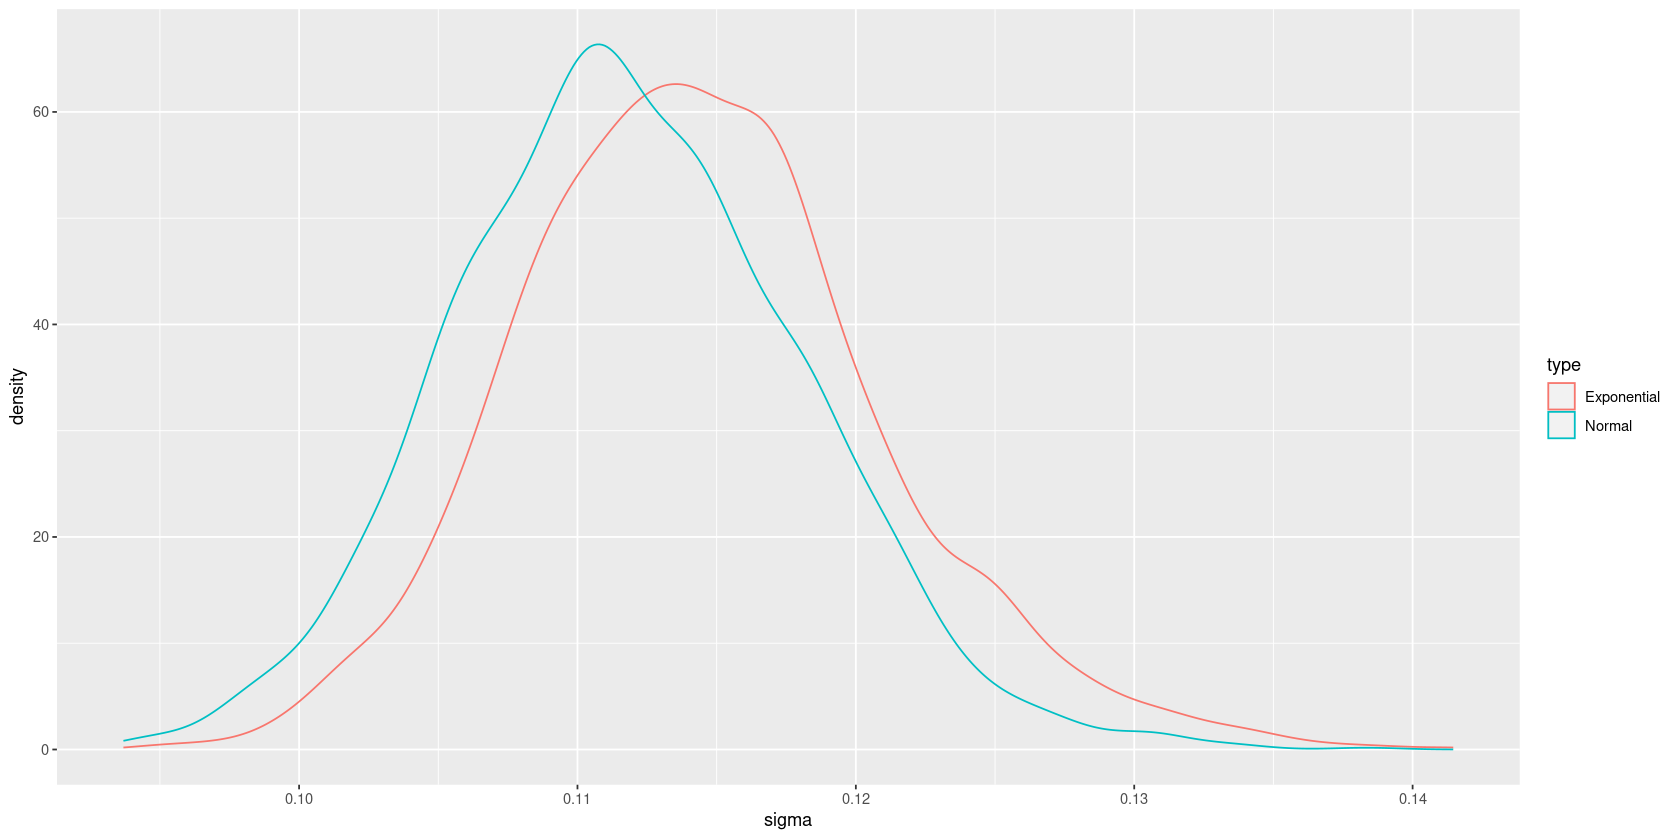

In [34]:
regular_posterior <- extract.samples(m9.1)
exponential_posterior <- extract.samples(m9.1_exponential)

plot_df <- rbind(
    data.frame(sigma=regular_posterior$sigma, type="Normal"),
    data.frame(sigma=exponential_posterior$sigma, type="Exponential")
)

ggplot(plot_df, aes(x=sigma, colour=type)) +
    geom_density()

In [35]:
precis(m9.1, depth=2)
precis(m9.1_exponential, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.8896325,0.016357429,0.86448784,0.91622582,2485.104,0.9994965
a[2],1.0497539,0.010019099,1.03395000,1.06516220,2395.818,0.9988111
b[1],0.1985297,0.074947176,0.07635544,0.32016598,2687.637,0.9988707
b[2],-0.1073657,0.055873633,-0.19619248,-0.01755392,2036.549,0.9999880
sigma,0.1117807,0.006213132,0.10215424,0.12168405,2212.050,0.9986146


,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.88770991,0.017079503,0.860817075,0.91497111,1903.293,1.0009861
a[2],1.04767908,0.010482225,1.030808900,1.06424165,2423.625,0.9993421
b[1],0.15123624,0.071430897,0.041248321,0.27220200,1156.165,0.9999134
b[2],0.01836572,0.017021000,0.001086187,0.05212952,2056.500,1.0009646
sigma,0.11438709,0.006484551,0.104730515,0.12537676,1811.052,1.0011417


The values are basically the same, but the `n_eff` for the one with the exponential prior is much lower. I don't know why!

#### 9M3 Re-estimate one of the **Stan** models from the chapter, but at different numbers of `warmup` iterations. Be sure to use the same number of sampling iterations in each case. Compare the `n_eff` values. How much warmup is enough?

In [36]:
set.seed(11)
ITER <- 2000
warmups <- c(seq(from=1, to=500, by=20), seq(from=500, to=2000, by=100))
df <- data.frame(warmup=double(), n_eff=double())
for (warmup in warmups) {
    # based on m9.3
    model <- ulam(
        alist(
            y ~ dnorm(mu, sigma),
            mu <- alpha,
            alpha ~ dnorm(1, 10),
            sigma ~ dexp(1)
        ),
        data=list(y=y),
        iter=ITER + warmup,
        warmup=warmup,
        refresh=0
    )
    p <- precis(model)
    n_eff <- p[2,"n_eff"]
    df <- rbind(df, data.frame(warmup=warmup, n_eff=n_eff))
}


Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 WARNING: No variance estimation is 
Chain 1          performed for num_warmup < 20 
Chain 1 finished in 0.0 seconds.


See https://mc-stan.org/misc/warnings for details.




Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 WARNING: There aren't enough warmup iterations to fit the 
Chain 1          three stages of adaptation as currently configured. 
Chain 1          Reducing each adaptation stage to 15%/75%/10% of 
Chain 1          the given number of warmup iterations: 
Chain 1            init_buffer = 3 
Chain 1            adapt_window = 16 
Chain 1            term_buffer = 2 
Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 WARNING: There aren't enough warmup iterations to fit the 
Chain 1          three stages of adaptation as currently configured. 
Chain 1          Reducing each adaptation stage to 15%/75%/10% of 
Chain 1          the given number of warmup iterations: 
Chain 1            init_buffer = 6 
Chain 1            adapt_window = 31 
Chain 1            term_buffer = 4 
Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 WARNING: T

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df453158e9.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 WARNING: There aren't enough warmup iterations to fit the 
Chain 1          three stages of adaptation as currently configured. 
Chain 1          Reducing each adaptation stage to 15%/75%/10% of 
Chain 1          the given number of warmup iterations: 
Chain 1            init_buffer = 21 
Chain 1            adapt_window = 106 
Chain 1            term_buffer = 14 
Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df69c7fb3.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df6d4915d9.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df1d02156.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df28705aef.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3dfafddb82.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df6ab8dcca.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df498c3c04.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df7fde6b2c.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df612a37a9.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df3f2192aa.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df6e19f154.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df6123b4d0.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df600f5610.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df5e423dc8.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpdRvLFi/model-3df41b4e88f.stan', line 13, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.


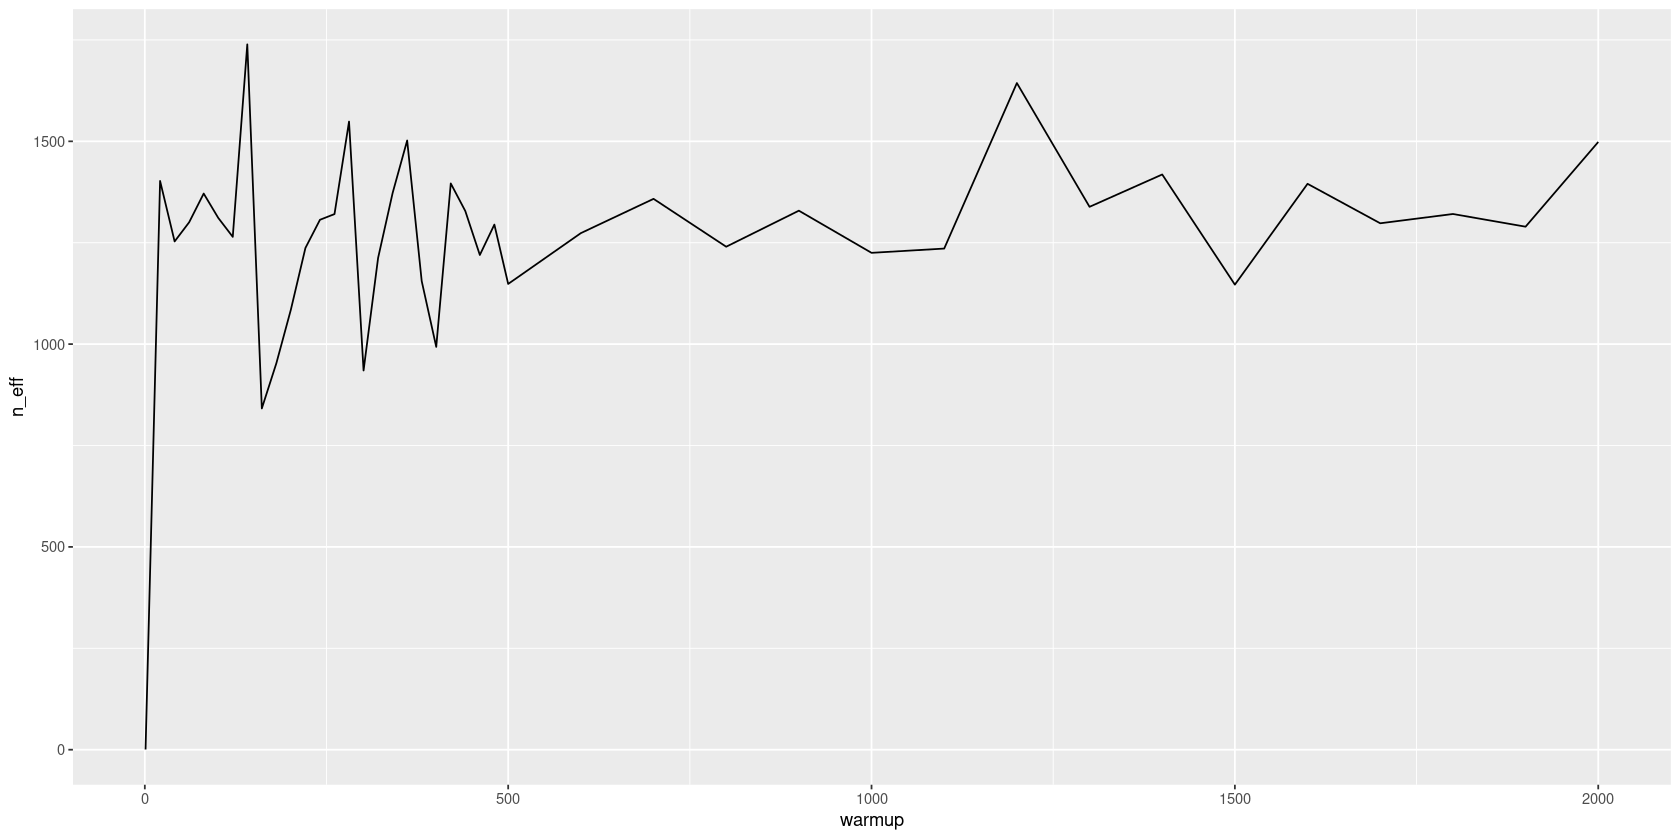

In [37]:
ggplot(df, aes(warmup, n_eff)) +
    geom_line()

From this, it seems like you don't need a long warmup phase, especially with such a simple model.

#### 9H1 Run the model below and then inspect the posterior distribution and explain what it is accomplishing.

In [41]:
mp <- ulam(
    alist(
        a ~ dnorm(0, 1),
        b ~ dcauchy(0, 1)
    ),
    data=list(y=y),
    chains=1,
    refresh=0
)
precis(mp)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 finished in 0.0 seconds.


,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.04964795,0.9860073,-1.623560,1.469242,109.3860,0.9987352
b,-0.02810669,3.7896126,-4.048712,4.724479,277.6376,0.9991760


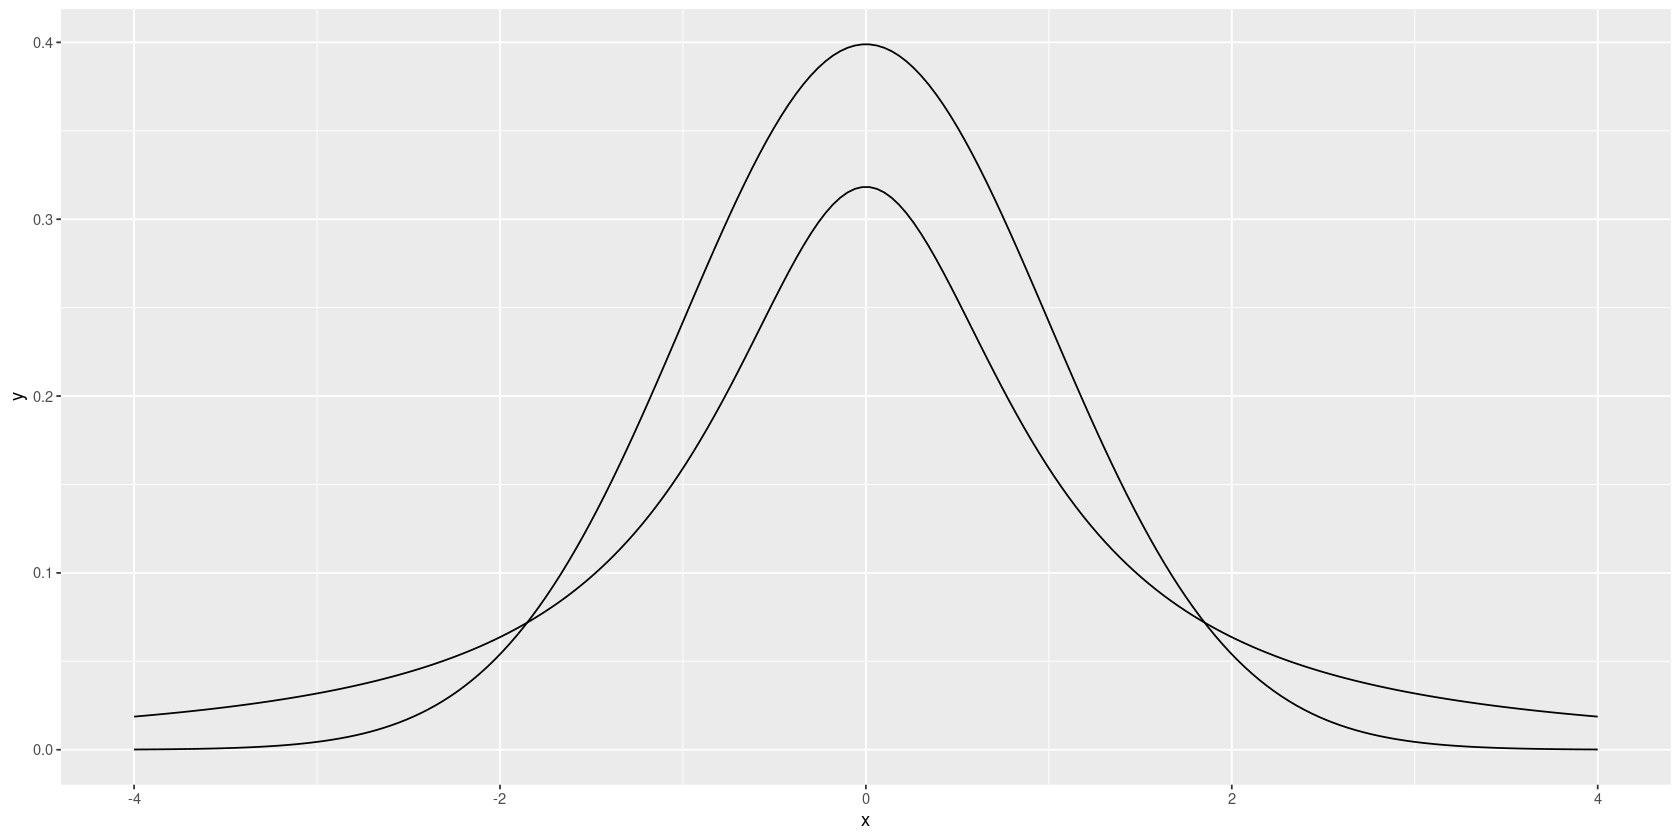

In [42]:
x <- seq(from=-4, to=4, length.out=200)
norm <- dnorm(x, 0, 1)
cauch <- dcauchy(x, 0, 1)

plot_df <- rbind(
    data.frame(x=x, y=norm, label="Normal"),
    data.frame(x=x, y=cauch, label="Cauchy")
)

ggplot(plot_df, aes(x, y, group=label)) +
    geom_line()

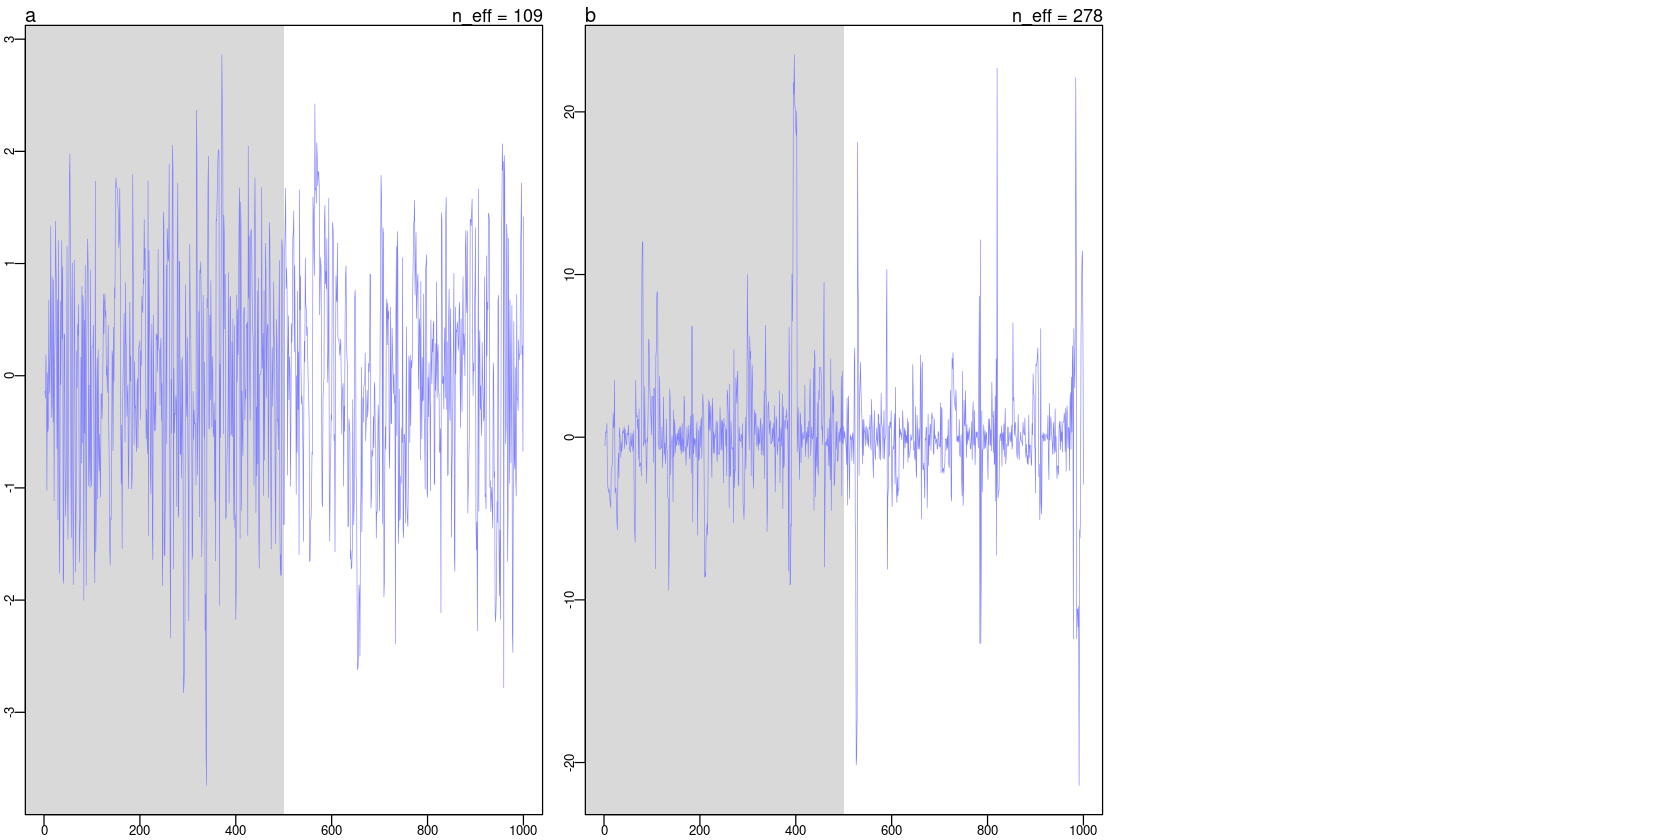

In [43]:
traceplot(mp)

Compare the samples for the parameters `a` and `b`. Can you explain the different trace plots? If you are unfamiliar with the Cauchy distribution, you should look it up. The key feature to attend to is that it has no expected value. Can you connect this fact to the trace plot?

The traceplot looks generally ok, but the parameter `b` has *enormous* spikes ($\pm$ 20). This is probably due to the fact that both the mean and standard deviation for the Cauchy distribution are undefined.

#### 9H2 Recall the divorce rate exaple from **Chapter 5**. Repeat that analysis, using `ulam` this time. fitting models `m5.1`, `m5.2`, and `m5.3`. Use `compare` to compare the models on the basis of WAIC or PSIS. To use PSIS or WAIC with `ulam`, you need that argument `log_log=TRUE`. Explain the model comparison results.

In [2]:

data(WaffleDivorce)
d <- WaffleDivorce
head(d)

# standardizing the data
d$D <- standardize(d$Divorce)
d$M <- standardize(d$Marriage)
d$A <- standardize(d$MedianAgeMarriage)

slim_data <- list(
    D=d$D,
    M=d$M,
    A=d$A
)

m5.1 <- ulam(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bA * A,
        a ~ dnorm(0, 0.2),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=slim_data,
    log_lik=TRUE,
    messages=FALSE
)

m5.2 <- ulam(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=slim_data,
    log_lik=TRUE,
    messages=FALSE
)

m5.3 <- ulam(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M + bA * A,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=slim_data,
    log_lik=TRUE,
    messages=FALSE
)
compare(m5.1, m5.2, m5.3)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.00


Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/RtmpEvtBgB/model-4017426b3a6.stan', line 19, column 4 to column 29)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%] 

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m5.1,125.8646,12.376600,0.0000000,NA,3.630168,0.5519152866
m5.3,126.2847,12.126386,0.4201441,0.8190469,4.056827,0.4473416052
m5.2,139.0852,9.537448,13.2206163,8.9233795,2.780844,0.0007431082


So `m5.1` and `m5.2` are basically as good as each other, with `m5.2` lagging behind.

#### 9H3 Sometimes changing the prior for one parameter has unanticipated effects on other parameters. This is because when a parameter is highly correlated with another parameter in the posterior, the prior influences both parameters. Here's an example to work and think through.

Go back to the leg length example in **Chapter 6** and use the code there to simulate height and leg lengths for 100 imagined individuals. Below is the model you fit before, resulting in a highly correlated posterior for the two beta paraeters. This time, fit the model using `ulam`:

In [12]:
N <- 100
set.seed(909)
height <- rnorm(N, 10, 2)
leg_prop <- runif(N, 0.4, 0.5) # leg length as proportion of height
leg_left <- leg_prop * height + rnorm(N, 0, 0.02) # add some error
leg_right <- leg_prop * height + rnorm(N, 0, 0.02) # add some error

d <- data.frame(height, leg_left, leg_right)

m6.1s <- ulam(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + bl*leg_left + br*leg_right,
        a ~ dnorm(10, 100),
        bl ~ dnorm(2, 10),
        br ~ dnorm(2, 10),
        sigma ~ dexp(1)
    ),
    data=d,
    chains=4,
    start=list(a=10, bl=0, br=0.1, sigma=1),
    log_lik=TRUE
)

Running MCMC with 4 sequential chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 2.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling)

See https://mc-stan.org/misc/warnings for details.




Compare the posterior distribution produced by the code above to the posterior distribution produced when you change the prior for `br` so that it is strictly positive:

In [13]:
m6.1s2 <- ulam(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + bl*leg_left + br*leg_right,
        a ~ dnorm(10, 100),
        bl ~ dnorm(2, 10),
        br ~ dnorm(2, 10),
        sigma ~ dexp(1)
    ),
    data=d,
    chains=4,
    constraints=list(br="lower=0"),
    start=list(a=10, bl=0, br=0.1, sigma=1),
    log_lik=TRUE
)

Running MCMC with 4 sequential chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 1.6 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling)

See https://mc-stan.org/misc/warnings for details.


See https://mc-stan.org/misc/warnings for details.




Note the `constraints` list. What this does is constrain the prior distribution of `br` so that it has positive probability only above zero. In other words, that prior ensures tha the posterior distribution for `br` will have no probability mass below zero. Compare the two posterior distributions for `m5.8s` and `m5.8s2`. Wht has changed in the posterior distribution of both beta parameters? Can you explain the change introduced by the change in prior?

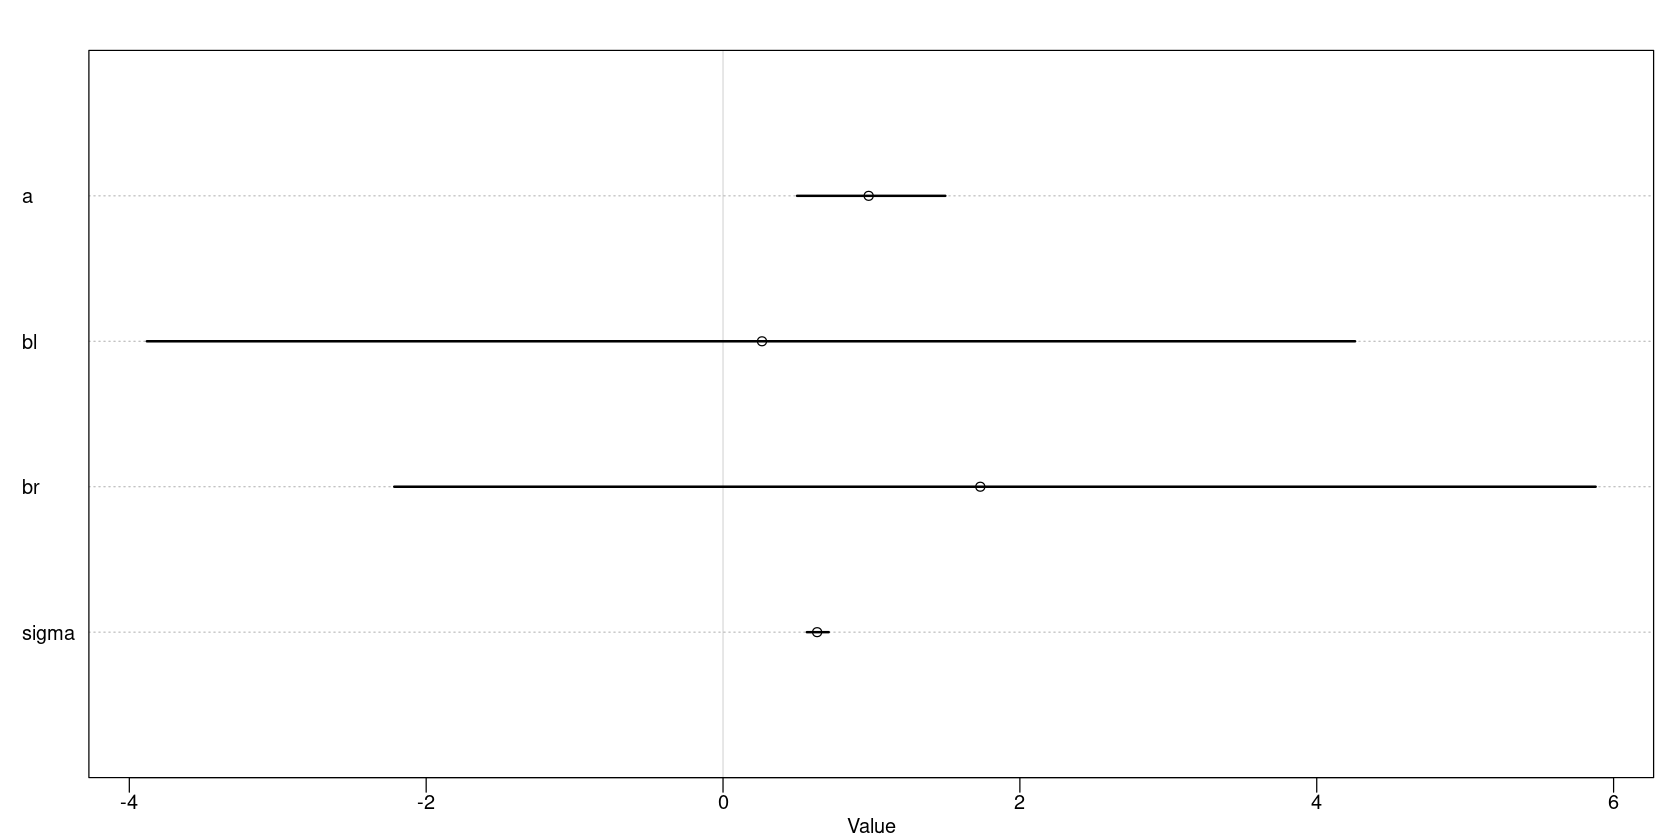

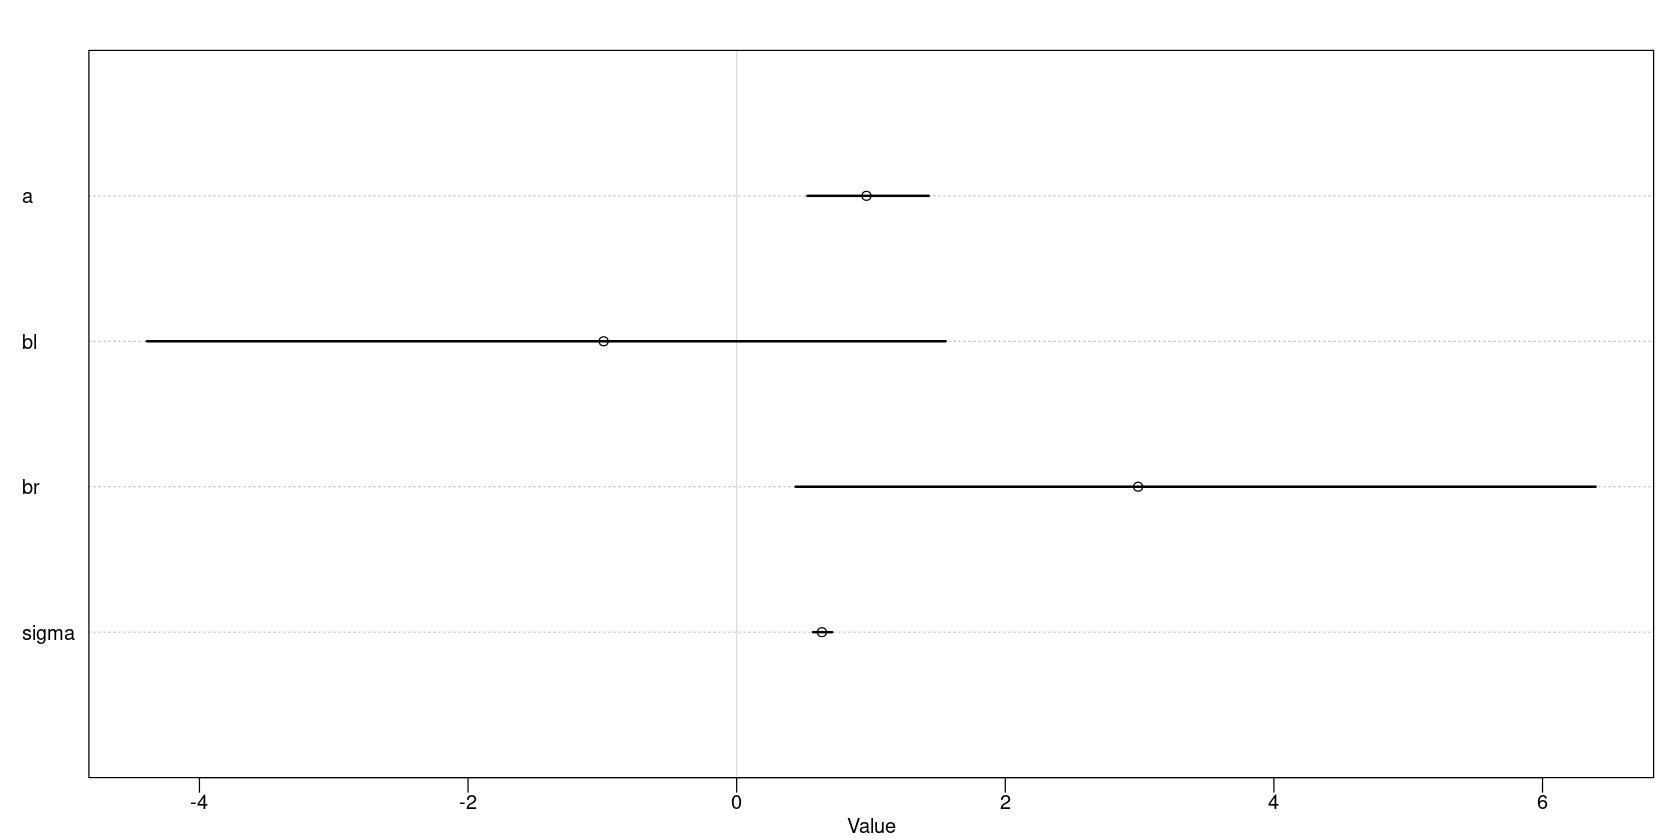

In [10]:
plot(precis(m6.1s))
plot(precis(m6.1s2))


In [11]:
precis(m6.1s)
precis(m6.1s2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9812159,0.30773398,0.4988936,1.497643,987.7118,1.000544
bl,0.2625415,2.58438819,-3.8818717,4.258359,547.0682,1.010899
br,1.7333588,2.58519157,-2.2150163,5.879102,549.9247,1.010953
sigma,0.6339462,0.04708526,0.5648907,0.711948,1087.4516,1.006173


,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9664384,0.28459827,0.5265384,1.430013,953.3490,0.9994617
bl,-0.9907439,1.90555928,-4.3915435,1.556004,521.2685,1.0037061
br,2.9889706,1.90663544,0.4391045,6.395520,521.2262,1.0037314
sigma,0.6346152,0.04497861,0.5691197,0.710930,960.5571,1.0015275


Constraining `br`, the coefficient of the right leg, to be positive has shifted `bl`, the coefficient of the left leg to be more negative that it otherwise would have been. This is because the left and right leg values are *basically* the same and 40% of the height; thus, the sum of the two coefficients should be about 1/40% = 2.5. 

#### 9H4 For the two models fit in the previous problem, use WAIC or PSIS to compare the effective number of parameters for each model. You will eed to use `log_lik=TRUE` to instruct `ulam` to compute the terms that both WAIC and PSIS need. Which model has more effective parameters? Why?

In [14]:
compare(m6.1s, m6.1s2)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.1s2,194.4002,11.31800,0.0000000,NA,2.850499,0.6117276
m6.1s,195.3093,11.18935,0.9091598,0.6695226,3.235905,0.3882724


`m6.1s`, the one wit no constraints, has the greater number of effective parameters `pWAIC`. This is because the effective parameter number is in some sense referring to the amount of freedom that the model has; since `m6.1s2` has a constraint on one of the parameters but is otherwise identical, this decreases the effective number of parameters.

#### 9H5 Modify the Metropolis algorithm code from the chapter to handle the case that the island populations have a different distribution than the island labels. This means the island's number will not be the same as its population.

In [17]:
NUM_WEEKS <- 1e4
positions <- rep(0, NUM_WEEKS) # island number on week n
position = 10
populations <- seq(from=1, to=10, by=1)
populations <- sample(populations, length(populations), replace=FALSE)
for (i in 1:NUM_WEEKS) {
    positions[i] <- position
    proposal_position <- ifelse(runif(1, 0, 1) < 0.5, position - 1, position + 1)
    # move it into the correct range
    if (proposal_position < 1) proposal_position <- 1
    if (proposal_position > 10) proposal_position <- 10
    prob_move <- populations[proposal_position] / populations[position]
    position <- ifelse(runif(1, 0, 1) < prob_move, proposal_position, position)
}

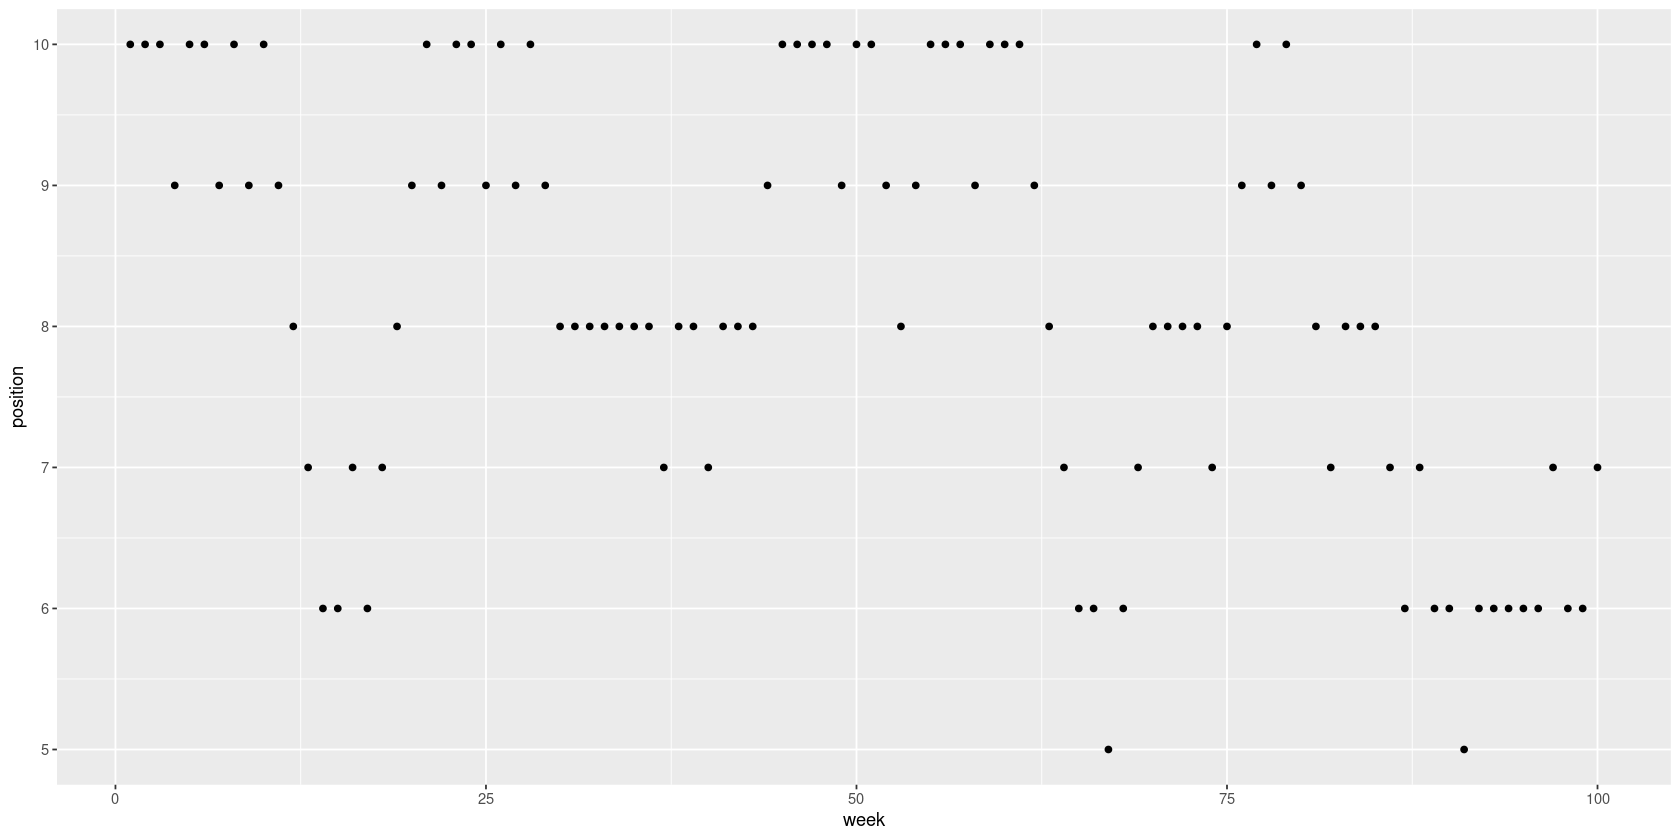

[1]  2  3  8  1  4 10  6  9  5  7

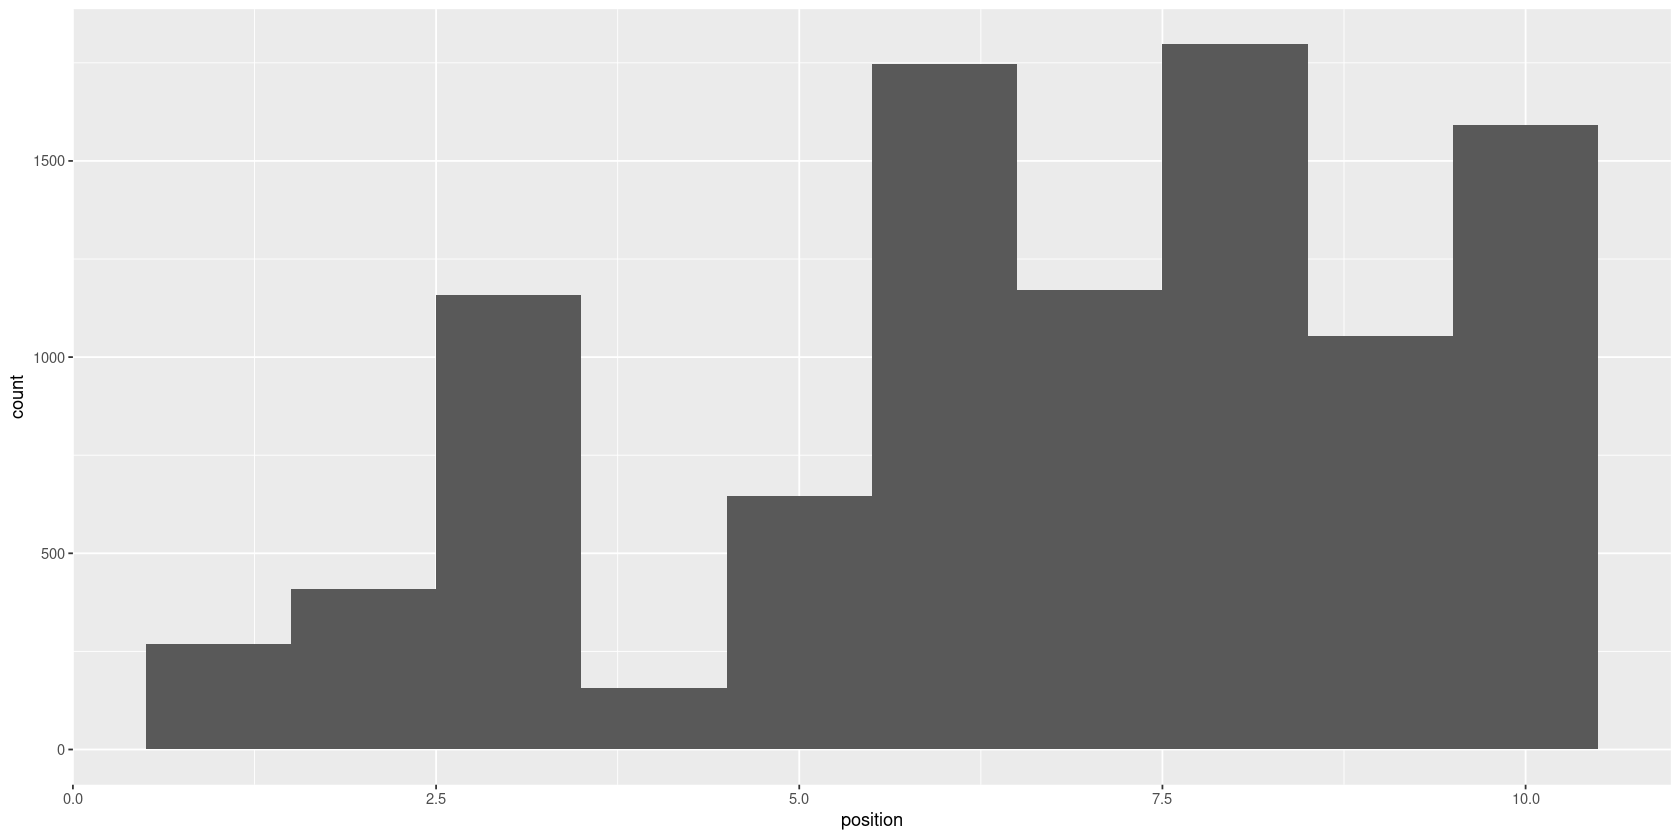

In [25]:
plot_df <- data.frame(week=1:NUM_WEEKS, position=positions)
truncated_plot_df <- data.frame(week=1:100, position=positions[1:100])

ggplot(truncated_plot_df, aes(week, position)) +
    geom_point()



ggplot(plot_df, aes(position)) +
    geom_histogram(binwidth=1)

populations

In [30]:
# NB This is a horrifying way to do it - there's almost surely a better way.
count <- rep(0, 10)
for (position in positions) {
    count[position] = count[position] + 1
}
freq <- count / length(positions)
hist_df <- rbind(
    data.frame(position=1:10, population=populations, freq=populations / sum(populations), type="Expected"),
    data.frame(position=1:10, population=populations, freq=freq, type="Actual")
)
hist_df

position,population,freq,type
<int>,<dbl>,<dbl>,<chr>
1,2,0.03636364,Expected
2,3,0.05454545,Expected
3,8,0.14545455,Expected
4,1,0.01818182,Expected
5,4,0.07272727,Expected
6,10,0.18181818,Expected
7,6,0.10909091,Expected
8,9,0.16363636,Expected
9,5,0.09090909,Expected


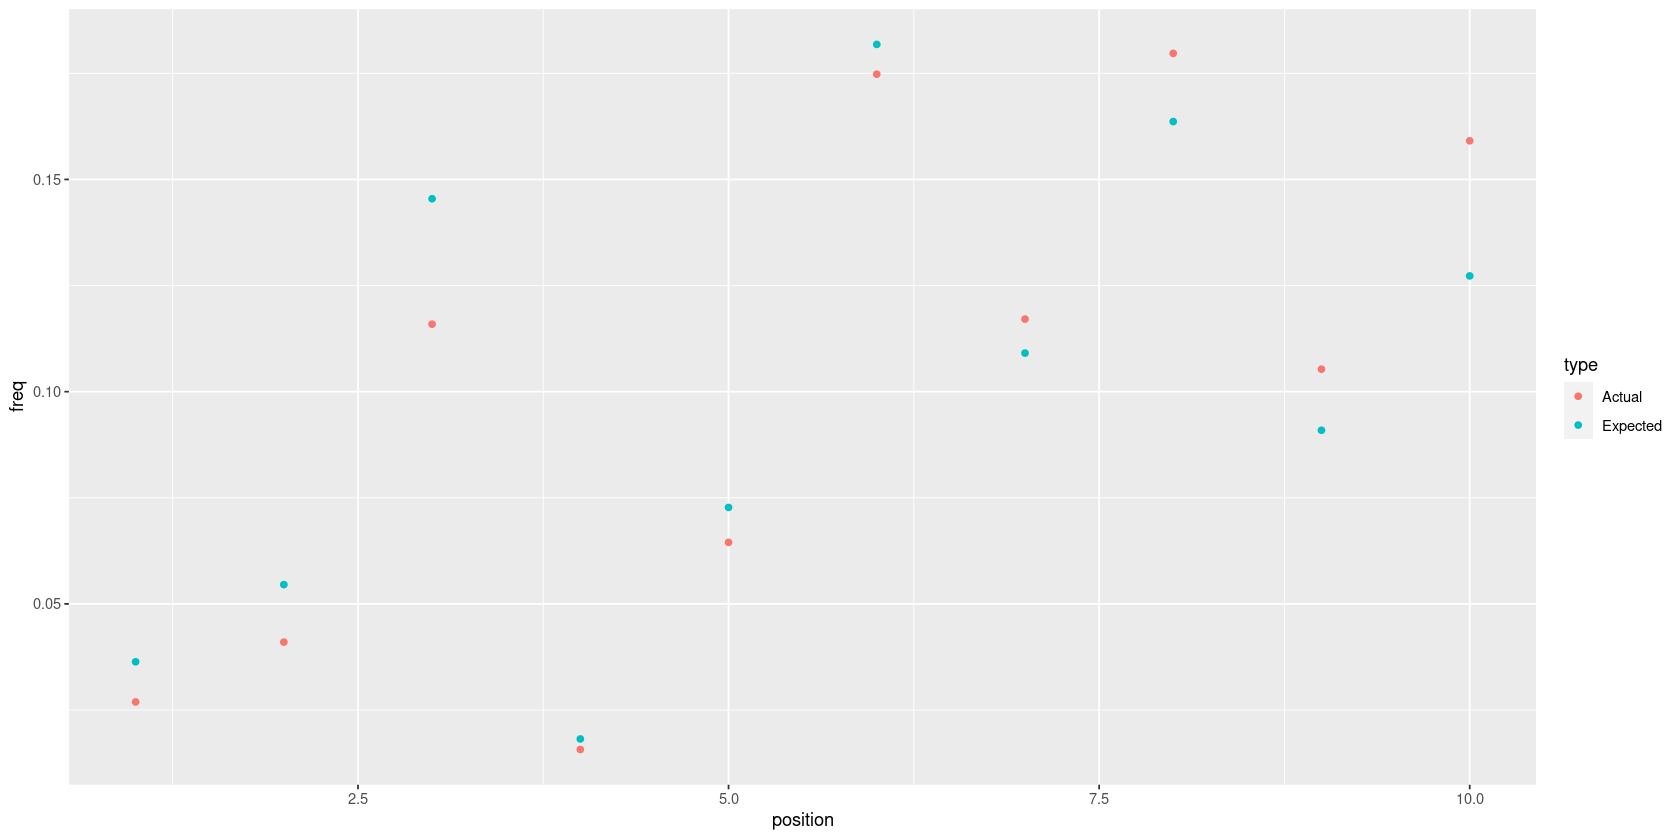

In [32]:
ggplot(hist_df, aes(position, freq)) +
    geom_point(aes(color=type))

#### 9H6 Modify the Metropolis algorithm code from the chapter to write your own simple MCMC estimator for glove tossing data and model from **Chapter 2**.

Reminder about **Chapter 2**: Tossing a globe. 6W, 3L. Start with a flat (uniform) prior, then see if we can change it to a beta one or something

From the chapter,
- Islands are the parameter values
- Population sizes are the posterior probabilities
- Weeks are the samples

We are trying to fit the model

$$
 \begin{align*}
    W &\sim \text{Binomial}(W+L, p) \\
    p &\sim \text{Uniform}(0, 1)
 \end{align*}
$$

In [41]:
# Set up the data and functions to calculate the posterior
W <- 6
L <- 3
prior_prob <- function(p) dunif(p, 0, 1)
likelihood <- function(p) dbinom(x=W, size=W+L, prob=p)
posterior_prob <- function(p) prior_prob(p) * likelihood(p)

NUM_SAMPLES <- 1e5
p_samples <- rep(0, NUM_SAMPLES)
p <- runif(1, 0, 1) # generate the first p. Only important thing is that is symmetrical; choosing a uniform does this
for (i in 1:NUM_SAMPLES) {
    p_samples[i] <- p
    proposal_p <- runif(1, 0, 1)
    prob_move <- posterior_prob(proposal_p) / posterior_prob(p)
    p <- ifelse(runif(1, 0, 1) < prob_move, proposal_p, p)
}
# p_samples

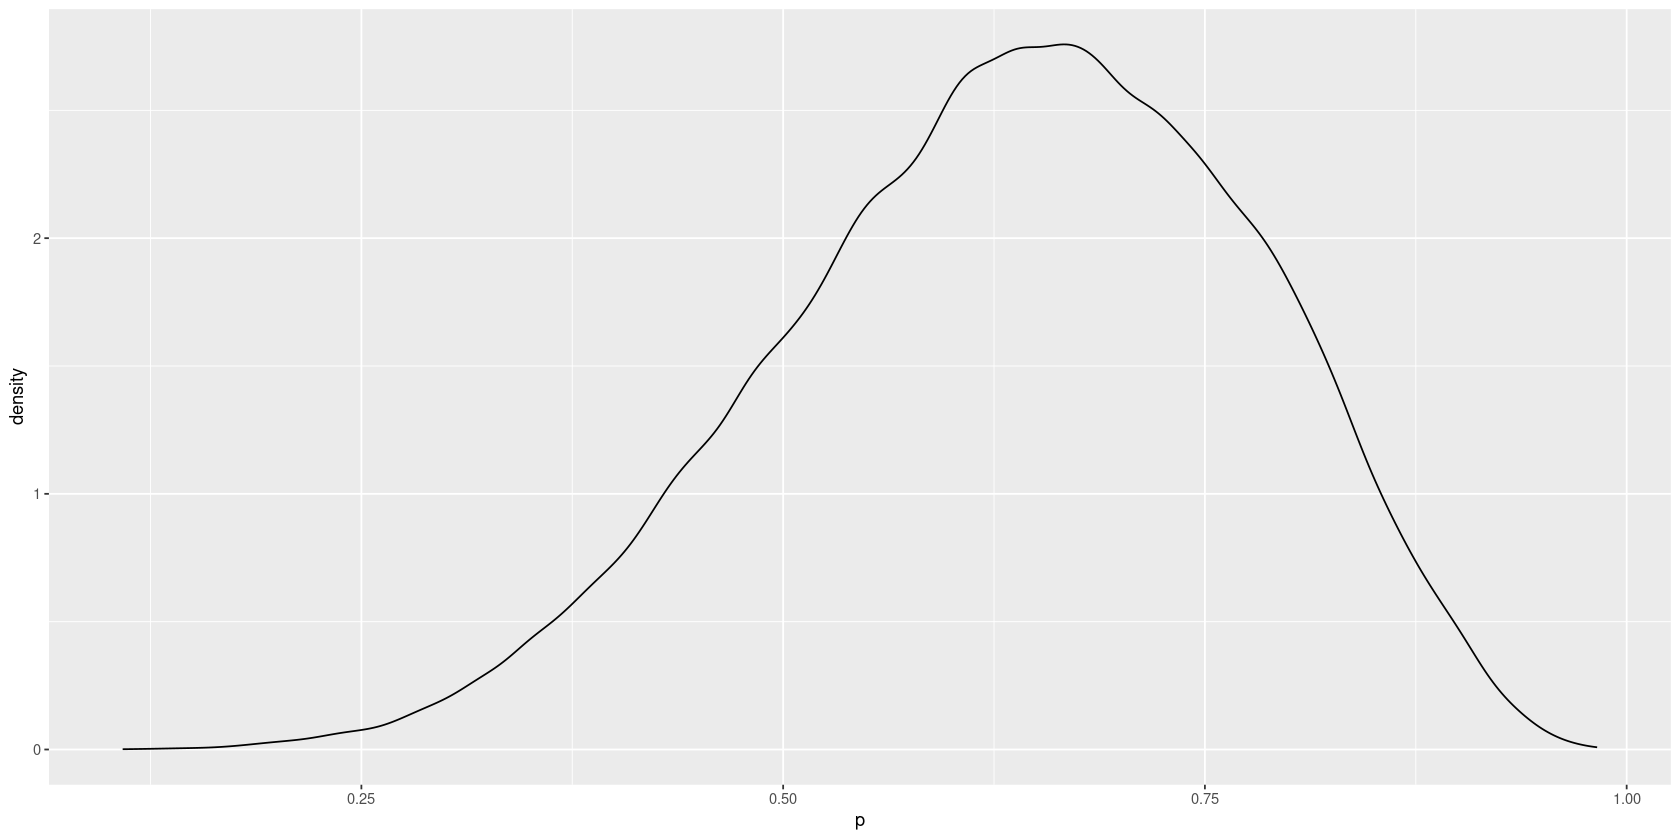

In [42]:
plot_df <- data.frame(p=p_samples)
ggplot(plot_df, aes(p)) +
    geom_density()

#### 9H7 Can you write your own Hamiltonian Monte Carlo algorithm for the globe tossing data, using the **R** code from this chapter? You will have to write you own functions for the likelihood and gradient, but can use the `HMC2` function.